# More examples

## Importing packages

In the examples below, we will be using the three main classes `ConformalClassifier`, `ConformalRegressor`, and `ConformalPredictiveSystem` from the `crepes` package, as an alternative to using the classes `WrapClassifier` and `WrapRegressor` in the same package, which was illustrated [here](https://crepes.readthedocs.io/en/latest/crepes_nb_wrap.html). In the examples, we will be using a helper class and functions from `crepes.extras` as well as `NumPy`, `pandas`, `matplotlib` and `sklearn`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from scipy.stats import kstest

from crepes import (ConformalClassifier, 
                    ConformalRegressor, 
                    ConformalPredictiveSystem, 
                    __version__)

from crepes.extras import hinge, margin, binning, DifficultyEstimator

print(f"crepes v. {__version__}")

np.random.seed(602211023)

crepes v. 0.8.0


## Conformal classifiers (CC)

### Importing and splitting a classification dataset

Let us import a classification dataset from [www.openml.org](https://www.openml.org).

In [2]:
dataset = fetch_openml(name="gas-drift", parser="auto")

X = dataset.data.values.astype(float)
y = dataset.target.values

We now split the dataset into a training and a test set, and further split the training set into a proper training set and a calibration set.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

### Standard conformal classifier

Let us first create and fit a random forest in the usual way (using the proper training set only):

In [4]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)

rf.fit(X_prop_train, y_prop_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

Let us also calculate non-conformity scores for the calibration set using the `hinge` function imported from `crepes.extras`, which takes predicted probabilities, class names and labels as input:

In [5]:
alphas_cal = hinge(rf.predict_proba(X_cal), rf.classes_, y_cal)

Using the non-conformity scores, we create and fit a standard conformal classifier by:

In [6]:
cc_std = ConformalClassifier()

cc_std.fit(alphas_cal)

display(cc_std)

ConformalClassifier(fitted=True, mondrian=False)

In order to make predictions for a test set, we need non-conformity scores for this too; note that class names and labels should not be provided in this case:

In [7]:
alphas_test = hinge(rf.predict_proba(X_test))

We obtain p-values for the test set from the non-conformity scores by:

In [8]:
cc_std.predict_p(alphas_test)

array([[7.11853998e-02, 6.81623163e-04, 7.51952414e-05, 7.22822111e-03,
        1.83551541e-03, 1.25354912e-03],
       [7.69995483e-04, 4.02198309e-01, 3.28246348e-03, 8.46337362e-04,
        1.03880711e-03, 1.29555038e-03],
       [1.65747617e-03, 1.16900791e-03, 2.02917868e-04, 5.02167131e-05,
        7.65836044e-01, 1.70578620e-03],
       ...,
       [1.30852359e-03, 1.38763636e-03, 2.20624808e-03, 4.54321090e-03,
        2.99559728e-03, 2.06218609e-01],
       [1.89321540e-03, 1.75937091e-03, 1.64400289e-03, 6.98791143e-03,
        2.22087512e-03, 1.16866012e-01],
       [2.90605130e-03, 1.94900613e-03, 1.74838116e-03, 3.30855703e-03,
        7.68918667e-02, 7.03350329e-03]])

If we want only the p-values for the correct labels, we need to provide the class names together with the labels and set `all_classes=False`:

In [9]:
p_values = cc_std.predict_p(alphas_test, all_classes=False, classes=rf.classes_, y=y_test)
display(p_values)

array([0.06903153, 0.40886435, 0.74415504, ..., 0.20719285, 0.11680768,
       0.07797522])

Let us take a look at how the p-values are distributed. From the visual inspection they may appear be approximaly uniformly distributed; this is however not guaranteed, since the p-values are not independent (see further below for semi-online conformal classifiers, for which this indeed holds). It is hence not very surprising if the Kolmogorov-Smirnov test allows us to reject that the p-values are sampled from a uniform distribution. 

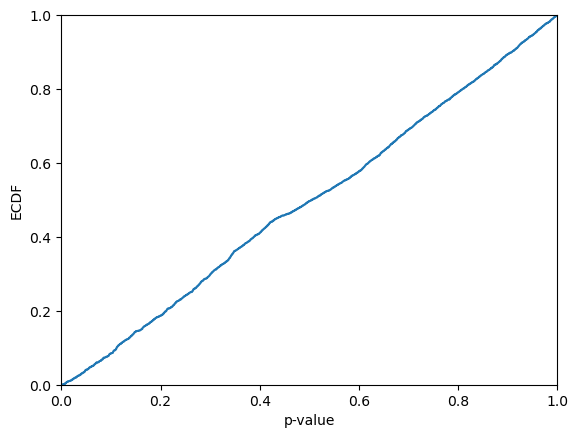

KS-test: 0.0006403345328411814


In [10]:
plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

We can also obtain predictions sets, i.e., binary vectors indicating the presence (1) or absence (0) of each class label, for some specified confidence level (the default is 0.95):

In [11]:
cc_std.predict_set(alphas_test, confidence=0.95)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

We may also evaluate the predictions; here using all available metrics, which is the default:

In [12]:
cc_std.evaluate(alphas_test, rf.classes_, y_test, confidence=0.99)

{'error': 0.0060388209920920755,
 'avg_c': 1.0031631919482387,
 'one_c': 0.9939611790079079,
 'empty': 0.0014378145219266715,
 'ks_test': 0.0010132423204891204,
 'time_fit': 1.1920928955078125e-06,
 'time_evaluate': 0.5879888534545898}

Alternatively, we could calculate non-conformity scores using the `margin` function, also imported from `crepes.extras`, which similar to `hinge`, takes predicted probabilities, class names and labels as input:

In [13]:
alphas_margin_cal = margin(rf.predict_proba(X_cal), rf.classes_, y_cal)

Using the new non-conformity scores, we create and fit a standard conformal classifier by:

In [14]:
cc_margin_std = ConformalClassifier()

cc_margin_std.fit(alphas_margin_cal)

display(cc_margin_std)

ConformalClassifier(fitted=True, mondrian=False)

In order to make predictions for the test set, we again need the non-conformity scores for this too:

In [15]:
alphas_margin_test = margin(rf.predict_proba(X_test))

Let us again evaluate the predictions:

In [16]:
cc_margin_std.evaluate(alphas_margin_test, rf.classes_, y_test, confidence=0.99)

{'error': 0.005032350826743359,
 'avg_c': 1.004744787922358,
 'one_c': 0.9959741193386054,
 'empty': 0.0,
 'ks_test': 0.0017738716077521192,
 'time_fit': 9.5367431640625e-07,
 'time_evaluate': 0.5412647724151611}

### Mondrian conformal classifiers

To control the error level across different groups of objects of interest, we may use so-called Mondrian conformal classifiers.
A Mondrian conformal classifier is formed by providing the names of the categories
as an additional argument, named `bins`, for the `calibrate` method.

We can form the Mondrian categories in any way we like, as long as we only
use information that is available for both calibration and test instances;
this means that we may not use the target values for this purpose, since these will 
typically not be available for the test instances. 

For illustration, we will use the predicted labels as the categories:

In [17]:
bins_cal = rf.predict(X_cal)

cc_mond = ConformalClassifier()

cc_mond.fit(alphas_cal, bins_cal)

ConformalClassifier(fitted=True, mondrian=True)

To obtain p-values for the test objects, we need to provide bins for these too:

In [18]:
bins_test = rf.predict(X_test)

p_values = cc_mond.predict_p(alphas_test, bins_test)

display(p_values)

array([[4.67815127e-02, 1.69734886e-03, 2.50746844e-03, 1.63394165e-04,
        2.46329483e-03, 5.04112905e-05],
       [4.83370625e-03, 2.46841752e-01, 3.45797934e-03, 4.22414243e-03,
        2.12753306e-04, 4.09035343e-03],
       [2.27412549e-03, 5.09548038e-03, 7.51853959e-04, 9.92062719e-04,
        6.74532915e-01, 4.36909349e-03],
       ...,
       [1.45080170e-03, 3.81770988e-03, 1.25495454e-03, 1.04800655e-02,
        1.09056431e-02, 3.38221369e-01],
       [1.17457748e-03, 3.23834150e-04, 1.03677912e-03, 1.07129487e-02,
        1.40005882e-03, 1.75214512e-01],
       [6.45127586e-03, 5.60947271e-03, 7.53524791e-03, 6.73571520e-03,
        8.61769871e-02, 1.32702940e-02]])

Similarly, prediction sets are obtained by:

In [19]:
prediction_sets = cc_mond.predict_set(alphas_test, bins_test, confidence=0.8)

display(prediction_sets)

array([[0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

Bins also have to be provided for the test objects when evaluating a Mondrian conformal classifier:

In [20]:
cc_mond.evaluate(alphas_test, rf.classes_, y_test, bins_test, 0.9)

{'error': 0.08828181164629767,
 'avg_c': 0.9128684399712437,
 'one_c': 0.9128684399712437,
 'empty': 0.08713156002875629,
 'ks_test': 0.00016153838740705104,
 'time_fit': 1.9073486328125e-06,
 'time_evaluate': 0.4615354537963867}

### Class-conditional conformal classifiers

Class-conditional conformal classifiers is a special type of Mondrian conformal classifiers where the categories simply are defined by the class labels.
The fitting is hence straightforward:

In [21]:
cc_class_cond = ConformalClassifier()

cc_class_cond.fit(alphas_cal, y_cal)

display(cc_class_cond)

ConformalClassifier(fitted=True, mondrian=True)

However, the test objects need special treatment since we do not know to which categories they belong. Below we show how to obtain the prediction sets:

In [22]:
prediction_set = np.array([
                cc_class_cond.predict_set(alphas_test,
                                          np.full(len(alphas_test),
                                                  rf.classes_[c]),
                                          confidence=0.9)[:, c]
    for c in range(len(rf.classes_))]).T

display(prediction_set)

array([[0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0]])

For easy handling of class-conditional conformal classifiers, you are advised to consider using the class `WrapClassifier`, which is illustrated [here](https://crepes.readthedocs.io/en/latest/crepes_nb_wrap.html).

### Semi-online conformal classifiers

The above conformal classifiers are fitted once using the provided calibration set. In case we are receiving the correct label for each test object immediately after making a prediction, we may consider the option of employing *online calibration*, i.e., continuously updating the calibration set. This is achieved by using the methods `predict_p_online` and `predict_set_online`, and can also be employed for the method `evaluate`. 

#### Online calibration with a fitted conformal classifier

Here we will obtain p-values computed in an online fashion for the above fitted standard conformal classifier. Note that in addition to the non-conformity scores for the test objects, we also need to provide the class names and correct labels.

In [23]:
cc_std.predict_p_online(alphas_test, rf.classes_, y_test)

array([[7.03496206e-02, 3.26291149e-04, 1.20839403e-03, 7.10008218e-03,
        1.89501070e-03, 2.00591859e-03],
       [4.84015535e-04, 4.11804656e-01, 3.16568852e-03, 1.08488224e-03,
        4.04066328e-04, 1.35227297e-03],
       [1.27639050e-03, 1.02906101e-03, 2.65614250e-04, 5.60501827e-04,
        7.73156018e-01, 1.63236994e-03],
       ...,
       [3.88178234e-04, 4.15242064e-04, 5.32165064e-04, 2.12132015e-03,
        9.71968577e-04, 1.95695446e-01],
       [5.14196991e-04, 5.24863027e-04, 4.00023514e-04, 2.92939004e-03,
        5.20350239e-04, 1.09893314e-01],
       [1.01563077e-03, 4.97778204e-04, 4.86513714e-04, 1.00895998e-03,
        6.64261107e-02, 3.23908096e-03]])

In [24]:
cc_margin_std.predict_p_online(alphas_margin_test, rf.classes_, y_test)

array([[5.44635675e-02, 2.63759579e-03, 2.52506734e-03, 3.80470638e-03,
        2.57716493e-03, 2.47015068e-03],
       [4.98036676e-04, 3.79600838e-01, 3.13976689e-04, 4.05794154e-04,
        5.40015122e-04, 4.09819455e-04],
       [5.73602264e-04, 3.68361230e-04, 3.99284233e-04, 2.58216542e-04,
        7.82910155e-01, 2.51742639e-04],
       ...,
       [2.86212177e-04, 2.96816199e-04, 2.50256022e-04, 1.10297473e-03,
        4.10424600e-04, 1.87963683e-01],
       [1.14720370e-03, 1.11185054e-03, 1.14160528e-03, 1.49979666e-03,
        1.07679511e-03, 9.27042232e-02],
       [1.29637172e-03, 1.31100052e-03, 1.37545421e-03, 1.44664456e-03,
        5.93376897e-02, 1.78404656e-03]])

In [25]:
cc_mond.predict_p_online(alphas_test, rf.classes_, y_test, bins_test)

array([[4.48059805e-02, 6.71703952e-04, 2.48568236e-03, 6.84500399e-04,
        2.67837470e-03, 5.33002239e-04],
       [2.31184317e-03, 2.40587298e-01, 3.29967430e-03, 5.09420132e-03,
        3.61705759e-03, 2.74639805e-03],
       [3.92011815e-03, 3.52331145e-03, 5.10723260e-03, 2.91507800e-04,
        7.34407027e-01, 4.78049603e-03],
       ...,
       [3.18338047e-04, 2.83669840e-04, 7.22558772e-04, 2.00569828e-03,
        2.24302949e-03, 2.96396627e-01],
       [3.32280765e-04, 1.09261117e-04, 2.35754573e-04, 2.37650421e-03,
        1.73951595e-04, 1.37069775e-01],
       [2.58686922e-03, 1.87851604e-03, 1.95985352e-03, 2.74904103e-03,
        7.44906695e-02, 8.16679479e-03]])

If we want only the p-values for the correct labels, when can set `all_classes=False`: 

In [26]:
p_values = cc_std.predict_p_online(alphas_test, rf.classes_, y_test, all_classes=False)

Let us take a look at how the p-values are distributed. In contrast to when using standard inductive conformal classifiers, we now expect the p-values to be distributed uniformly, since online calibration is employed. Hence, this should only rarely be rejected by the Kolmogorov-Smirnov test.

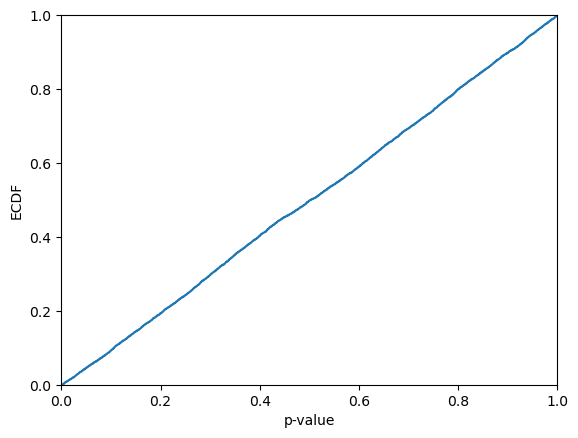

KS-test: 0.353471098223197


In [27]:
plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

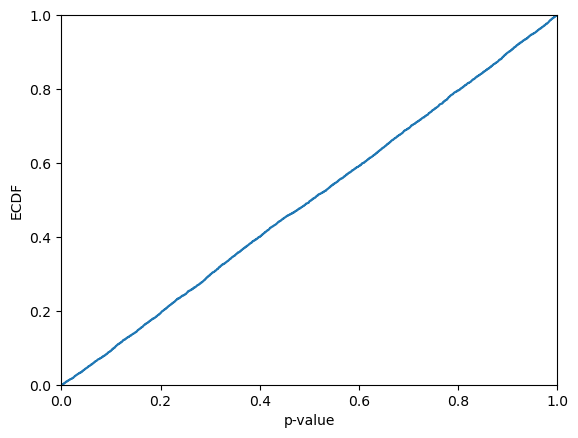

KS-test: 0.554108159857639


In [28]:
p_values = cc_margin_std.predict_p_online(alphas_margin_test, rf.classes_, y_test, all_classes=False)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

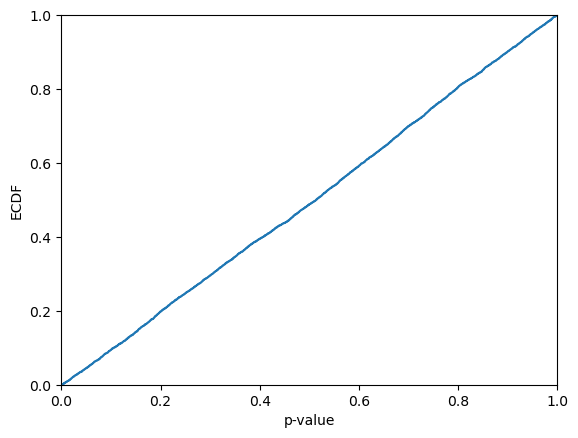

KS-test: 0.1155019010434083


In [29]:
p_values = cc_mond.predict_p_online(alphas_test, rf.classes_, y_test, bins_test, all_classes=False)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

Similarly, we can obtain prediction sets based on the p-values computed online, which are compared to the specified level of confidence:

In [30]:
cc_std.predict_set_online(alphas_test, rf.classes_, y_test)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

By default, the test objects and labels are sequentially added to the existing calibration set, i.e., the one used when fitting the conformal classifier. If we would like the original calibration set to be ignored, we can set the `warm_start` option to `False`. Note that few (if any) class labels will be excluded from the initial prediction sets, before we have a sufficiently large calibration set to allow for excluding labels at the specified level of confidence.

In [31]:
cc_mond.predict_set_online(alphas_test, rf.classes_, y_test, bins_test, 
                           confidence=0.99, warm_start=False)

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

We may also evaluate the conformal classifier using online calibration, by specifying `online=True` for the `evaluate` method:

In [32]:
cc_margin_std.evaluate(alphas_margin_test, rf.classes_, y_test, 
                       confidence=0.99, online=True)

{'error': 0.00833932422717465,
 'avg_c': 0.9962616822429906,
 'one_c': 0.9962616822429906,
 'empty': 0.003738317757009346,
 'ks_test': 0.47482742902948305,
 'time_fit': 9.5367431640625e-07,
 'time_evaluate': 0.7731363773345947}

Again, we may consider ignoring the original calibration set by setting `warm_start=False`:

In [33]:
cc_margin_std.evaluate(alphas_margin_test, rf.classes_, y_test, 
                       confidence=0.99, online=True, warm_start=False)

{'error': 0.009920920201293981,
 'avg_c': 1.0294751976994967,
 'one_c': 0.982314881380302,
 'empty': 0.006326383896477355,
 'ks_test': 0.9563547223369226,
 'time_fit': 9.5367431640625e-07,
 'time_evaluate': 0.6956121921539307}

#### Online calibration without an initial calibration set

Since the calibration set is incrementally extended during online calibration, we may consider starting with an empty calibration set; this allows us to use the full training set when fitting the conformal classifier. 

In [34]:
rf_full = RandomForestClassifier(n_jobs=-1, n_estimators=500)

rf_full.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

Let us compute non-conformity scores for the test set using the model trained on the full training set:

In [35]:
alphas_test = hinge(rf_full.predict_proba(X_test), rf.classes_)

We may now create a conformal classifier, but this time without fitting a calibration set:

In [36]:
cc_full = ConformalClassifier()

We may now obtain prediction sets while sequentially updating the calibration set:

In [37]:
cc_full.predict_set_online(alphas_test, rf.classes_, y_test, confidence=0.9)

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1],
       [1, 0, 1, 1, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

Mondrian classification is conducted by also providing the categories for the test set:

In [38]:
bins_test = rf_full.predict(X_test)

cc_full.predict_set_online(alphas_test, rf.classes_, y_test, bins_test,
                           confidence=0.9)

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

Let us investigate the coverage and prediction set size for each class:

In [39]:
prediction_sets = cc_full.predict_set_online(alphas_test, rf.classes_, y_test,
                                             bins_test, confidence=0.9)

for i, c in enumerate(rf.classes_):
    selection = y_test == c
    coverage = np.sum(prediction_sets[selection][:,i])/np.sum(selection)
    size = np.sum(prediction_sets[selection])/np.sum(selection)
    print(f"Class: {c} Coverage: {coverage:.4f} Size: {size:.4f}")

Class: 1 Coverage: 0.9027 Size: 0.9206
Class: 2 Coverage: 0.9001 Size: 0.9164
Class: 3 Coverage: 0.9021 Size: 0.9359
Class: 4 Coverage: 0.9020 Size: 0.9195
Class: 5 Coverage: 0.9062 Size: 0.9216
Class: 6 Coverage: 0.9043 Size: 0.9285


We can use `predict_p_online` to get the p-values:

array([0.07870199, 0.09473235, 0.55178404, ..., 0.32500334, 0.09549978,
       0.09122852])

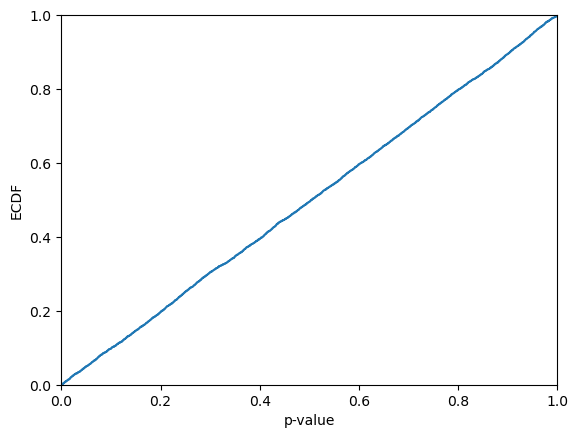

KS-test: 0.7179206900620947


In [40]:
p_values = cc_full.predict_p_online(alphas_test, rf.classes_, y_test, 
                                    bins=bins_test, all_classes=False)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

We may also evaluate the conformal classifier using online calibration, by specifying `online=True` for the `evaluate` method:

In [41]:
cc_full.evaluate(alphas_test, rf.classes_, y_test, confidence=0.9, online=True)

{'error': 0.09877785765636238,
 'avg_c': 0.904529115744069,
 'one_c': 0.901078360891445,
 'empty': 0.09791516894320633,
 'ks_test': 0.9125050366201575,
 'time_fit': None,
 'time_evaluate': 0.699739933013916}

Similar for Mondrian classification, where we provide the categories:

In [42]:
cc_full.evaluate(alphas_test, rf.classes_, y_test, bins_test, confidence=0.9, 
                 online=True)

{'error': 0.09805895039539902,
 'avg_c': 0.9216391085549964,
 'one_c': 0.8970524802300504,
 'empty': 0.09676491732566499,
 'ks_test': 0.4291756869646982,
 'time_fit': None,
 'time_evaluate': 0.5608727931976318}

### Out-of-bag calibration

For conformal classifiers that employ learners that use bagging, like random forests, we may consider an alternative strategy to dividing the original training set into a proper training and calibration set; we may use the out-of-bag (OOB) predictions, which allow us to use the full training set for both model building and calibration. It should be noted that this strategy does not come with the theoretical validity guarantee of the above (inductive) conformal classifiers, due to that calibration and test instances are not handled in exactly the same way. In practice, however, conformal classifiers based on out-of-bag predictions rarely fail to meet the coverage requirements.

#### Standard conformal classifiers with out-of-bag calibration

Let us first generate a model from the full training set, making sure the learner has an attribute `oob_decision_function_`, which e.g. is the case for a `RandomForestClassifier` if `oob_score` is set to `True` when created.

In [43]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, oob_score=True)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True)

We may now obtain a standard conformal regressor using OOB predictions:

In [44]:
alphas_oob = hinge(rf.oob_decision_function_, rf.classes_, y_train)

cc_std_oob = ConformalClassifier()

cc_std_oob.fit(alphas_oob)

display(cc_std_oob)

ConformalClassifier(fitted=True, mondrian=False)

... and use it to get prediction sets for the test set:

In [45]:
alphas_test = hinge(rf.predict_proba(X_test))

prediction_sets_oob = cc_std_oob.predict_set(alphas_test)

display(prediction_sets_oob)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

#### Mondrian conformal classifiers with out-of-bag calibration

Using out-of-bag calibration works equally well for Mondrian conformal classifiers. Here we form two categories by binning the values of the first feature using a certain threshold:

In [46]:
bins_oob = X_train[:,0] > 50000

cc_mond_oob = ConformalClassifier()

cc_mond_oob.fit(alphas_oob, bins_oob)

display(cc_mond_oob)

ConformalClassifier(fitted=True, mondrian=True)

Prediction sets for the test objects are obtained in the following way:

In [47]:
bins_test = X_test[:,0] > 50000

prediction_sets_mond_oob = cc_mond_oob.predict_set(alphas_test, bins=bins_test)

display(prediction_sets_oob)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

We may of course evaluate the Mondrian conformal classifier using out-of-bag predictions too:

In [48]:
results = cc_mond_oob.evaluate(alphas_test, rf.classes_, y_test, bins=bins_test)

display(results)

{'error': 0.04543493889288286,
 'avg_c': 0.9557153127246585,
 'one_c': 0.9557153127246585,
 'empty': 0.04428468727534148,
 'ks_test': 2.229814212480889e-26,
 'time_fit': 4.76837158203125e-07,
 'time_evaluate': 0.6344108581542969}

## Conformal regressors (CR)

### Importing and splitting a regression dataset

Let us import a regression dataset from [www.openml.org](https://www.openml.org) and min-max normalize the targets; the latter is not really necessary, but useful, allowing to directly compare the size of a prediction interval to the whole target range, which becomes 1.0 in this case.

In [49]:
dataset = fetch_openml(name="house_sales", version=3, parser="auto")

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

y = np.array([(y[i]-y.min())/(y.max()-y.min()) for i in range(len(y))])

We now split the dataset into a training and a test set, and further split the training set into a proper training set and a calibration set. Let us fit a random forest to the proper training set.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

learner_prop = RandomForestRegressor(n_jobs=-1, n_estimators=500, oob_score=True) 

learner_prop.fit(X_prop_train, y_prop_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True)

### Standard conformal regressors

Let us create a conformal regressor.

In [51]:
cr_std = ConformalRegressor()

We may display the object, e.g., to see whether it has been fitted or not.

In [52]:
display(cr_std)

ConformalRegressor(fitted=False)

We will use the residuals from the calibration set to fit the conformal regressor. 

In [53]:
y_hat_cal = learner_prop.predict(X_cal)

residuals_cal = y_cal - y_hat_cal

cr_std.fit(residuals_cal)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

We may now obtain prediction intervals from the point predictions for the test set; 
here using a confidence level of 99%.

In [54]:
y_hat_test = learner_prop.predict(X_test)

intervals = cr_std.predict_int(y_hat_test, confidence=0.99)

display(intervals)

array([[-0.03419644,  0.09024183],
       [-0.00378046,  0.12065781],
       [ 0.10960205,  0.23404032],
       ...,
       [-0.01875442,  0.10568385],
       [-0.01854756,  0.10589071],
       [-0.03395386,  0.09048441]])

We may request that the intervals are cut to exclude impossible values, in this case below 0 and above 1; below we also use the default 
confidence level (95%), which further tightens the intervals.

In [55]:
intervals_std = cr_std.predict_int(y_hat_test, y_min=0, y_max=1)

display(intervals_std)

array([[0.        , 0.05877615],
       [0.02768522, 0.08919213],
       [0.14106773, 0.20257464],
       ...,
       [0.01271126, 0.07421817],
       [0.01291812, 0.07442503],
       [0.        , 0.05901873]])

If we want to obtain the p-values for the correct labels, we can use `predict_p`, and in addition to the point predictions also provide the correct labels:

In [56]:
p_values = cr_std.predict_p(y_hat_test, y_test)
display(p_values)

array([0.56223961, 0.1011105 , 0.84661324, ..., 0.36592385, 0.65350816,
       0.48107359])

Let us take a look at how the p-values are distributed. From the visual inspection they may appear be approximaly uniformly distributed; this is however not guaranteed, since the p-values are not independent (see further below for semi-online conformal regressors, for which this indeed holds). It is hence not very surprising if the Kolmogorov-Smirnov test allows us to reject that the p-values are sampled from a uniform distribution. 

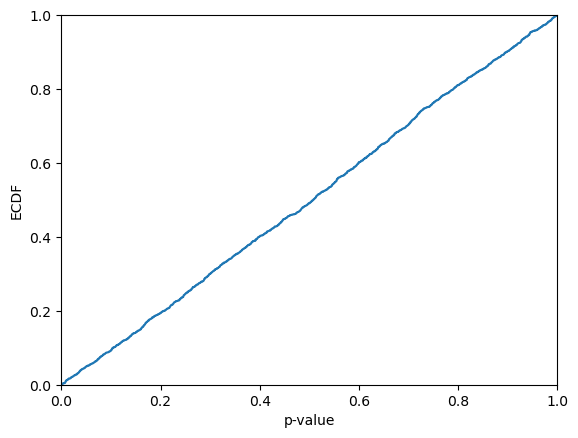

KS-test: 0.004320704598942889


In [57]:
plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

### Normalized conformal regressors

The above intervals are not normalized, i.e., they are all of the same size (at least before they are cut). We could make the intervals more informative through normalization using difficulty estimates; 
more difficult instances will be assigned wider intervals. We can use a `DifficultyEstimator`, as imported from `crepes.extras`,  for this purpose. It can be used to estimate the difficulty by using k-nearest neighbors in three different ways: i) by the (Euclidean) distances to the nearest neighbors, ii) by the standard deviation of the targets of the nearest neighbors, and iii) by the absolute errors of the k nearest neighbors. 

A small value (beta) is added to the estimates, which may be given through a (named) argument to the `fit` method; we will just use the default for this, i.e., `beta=0.01`. In order to make the beta value have the same effect across different estimators, we may opt for normalizing the difficulty estimates (using min-max scaling) by setting `scaler=True`. It should be noted that this comes with a computational cost; for estimators based on the k-nearest neighbor, a leave-one-out protocol is employed to find the minimum and maximum distances that are used by the scaler.

We will first consider just using the first option (distances to the k-nearest neighbors) to produce normalized conformal regressors, using the default number of nearest neighbors, i.e., `k=25`.

In [58]:
de_knn = DifficultyEstimator()

de_knn.fit(X=X_prop_train, scaler=True)

display(de_knn)

sigmas_cal_knn_dist = de_knn.apply(X_cal)

cr_norm_knn_dist = ConformalRegressor()

cr_norm_knn_dist.fit(residuals_cal, sigmas=sigmas_cal_knn_dist)

display(cr_norm_knn_dist)

DifficultyEstimator(fitted=True, type=knn, k=25, target=none, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

To generate prediction intervals for the test set, we need difficulty estimates for the latter too, which we get in the same way as for the calibration objects. 

In [59]:
sigmas_test_knn_dist = de_knn.apply(X_test)

intervals_norm_knn_dist = cr_norm_knn_dist.predict_int(y_hat_test, 
                                                       sigmas=sigmas_test_knn_dist,
                                                       y_min=0, y_max=1)

display(intervals_norm_knn_dist)

array([[0.00798752, 0.04805786],
       [0.00923534, 0.10764201],
       [0.14551656, 0.19812581],
       ...,
       [0.00674954, 0.08017989],
       [0.02848742, 0.05885573],
       [0.00361369, 0.05291686]])

Alternatively, we could estimate the difficulty using the standard deviation of the targets of the nearest neighbors; we specify this by providing the targets too:

In [60]:
de_knn_std = DifficultyEstimator()

de_knn_std.fit(X=X_prop_train, y=y_prop_train, scaler=True)

display(de_knn_std)

sigmas_cal_knn_std = de_knn_std.apply(X_cal)

cr_norm_knn_std = ConformalRegressor()

cr_norm_knn_std.fit(residuals_cal, sigmas=sigmas_cal_knn_std)

display(cr_norm_knn_std)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

... and similarly for the test objects:

In [61]:
sigmas_test_knn_std = de_knn_std.apply(X_test)

intervals_norm_knn_std = cr_norm_knn_std.predict_int(y_hat_test, 
                                                     sigmas=sigmas_test_knn_std,
                                                     y_min=0, y_max=1)

display(intervals_norm_knn_std)

array([[0.00997554, 0.04606985],
       [0.0083622 , 0.10851515],
       [0.11428189, 0.22936048],
       ...,
       [0.02492224, 0.06200719],
       [0.03373492, 0.05360823],
       [0.01768953, 0.03884102]])

A third option is to use (absolute) residuals for the reference objects. For a model that overfits the training data, it can be a good idea to use a separate set of (reference) objects and labels from which the residuals could be calculated, rather than using the original training data. Since we in this case have trained a random forest, we opt for estimating the residuals by using the out-of-bag predictions for the training instances. (This was made possible by setting `oob_score=True` for the `RandomForestRegressor` above.)

To inform the `fit` method that this is what we want to do, we provide a value for `residuals`, instead of `y` as we did above for the option to use the (standard deviation of) the targets.

In [62]:
oob_predictions = learner_prop.oob_prediction_

residuals_oob = y_prop_train - oob_predictions

de_knn_res = DifficultyEstimator()

de_knn_res.fit(X=X_prop_train, residuals=residuals_oob, scaler=True)

display(de_knn_res)

sigmas_cal_knn_res = de_knn_res.apply(X_cal)

cr_norm_knn_res = ConformalRegressor()

cr_norm_knn_res.fit(residuals_cal, sigmas=sigmas_cal_knn_res)

display(cr_norm_knn_res)

DifficultyEstimator(fitted=True, type=knn, k=25, target=residuals, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

... and again, the difficulty estimates are formed in the same way for the test objects:

In [63]:
sigmas_test_knn_res = de_knn_res.apply(X_test)

intervals_norm_knn_res = cr_norm_knn_res.predict_int(y_hat_test, 
                                                     sigmas=sigmas_test_knn_res,
                                                     y_min=0, y_max=1)

display(intervals_norm_knn_res)

array([[0.01392781, 0.04211757],
       [0.03329068, 0.08358667],
       [0.12801564, 0.21562673],
       ...,
       [0.03254232, 0.05438711],
       [0.0249979 , 0.06234526],
       [0.01982459, 0.03670596]])

In case we have trained an ensemble model, like a `RandomForestRegressor`, we could alternatively request `DifficultyEstimator` to estimate the difficulty by the variance of the predictions of the constituent models. This requires us to provide the trained model `learner` as input to `fit`, assuming that `learner.estimators_` is a collection of base models, each implementing the `predict` method; this holds e.g., for `RandomForestRegressor`. A set of objects (`X`) has to be provided only if we employ scaling (`scaler=True`).

In [64]:
de_var = DifficultyEstimator()

de_var.fit(X=X_prop_train, learner=learner_prop, scaler=True)

display(de_var)

sigmas_cal_var = de_var.apply(X_cal)

cr_norm_var = ConformalRegressor()

cr_norm_var.fit(residuals_cal, sigmas=sigmas_cal_var)

display(cr_norm_var)

DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

The difficulty estimates for the test set are generated in the same way:

In [65]:
sigmas_test_var = de_var.apply(X_test)

intervals_norm_var = cr_norm_var.predict_int(y_hat_test, 
                                             sigmas=sigmas_test_var, 
                                             y_min=0, y_max=1)

display(intervals_norm_var)

array([[0.01066626, 0.04537912],
       [0.03792043, 0.07895692],
       [0.12897819, 0.21466418],
       ...,
       [0.02409464, 0.06283479],
       [0.025898  , 0.06144515],
       [0.01104499, 0.04548555]])

We can use `predict_p` to get the p-values also for normalized conformal regressors:

array([0.50992568, 0.04797715, 0.92383003, ..., 0.33211523, 0.61919979,
       0.40766003])

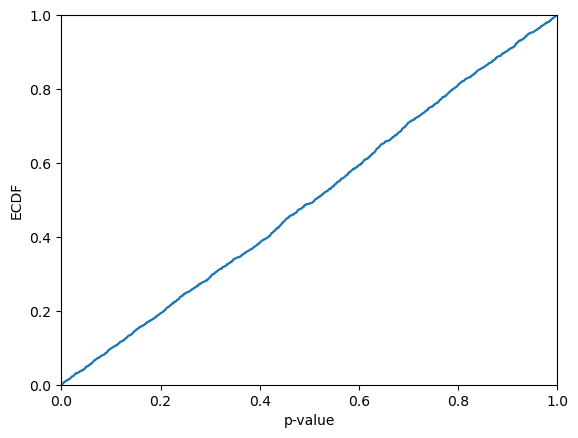

KS-test: 0.0019274177455422124


In [66]:
p_values = cr_norm_var.predict_p(y_hat_test, y_test, sigmas=sigmas_test_var)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

### Mondrian conformal regressors

An alternative way of generating prediction intervals of varying size
is to divide the object space into non-overlapping so-called Mondrian categories.
A Mondrian conformal regressor is formed by providing the names of the categories
as an additional argument, named `bins`, for the `fit` method.

Here we employ the helper function `binning`, imported from `crepes.extras`, which given a list/array of values
returns an array of the same length with the assigned bins. 
If the optional argument `bins` is an integer, the function will divide the values 
into equal-sized bins and return both the assigned bins and the bin boundaries. 
If `bins` instead is a set of bin boundaries, the function will just return the assigned bins.

We can form the Mondrian categories in any way we like, as long as we only
use information that is available for both calibration and test instances;
this means that we may not use the target values for this purpose, since these will 
typically not be available for the test instances. 
We will form categories by binning of the difficulty estimates, here using the
ones previously produced using the standard deviations of the nearest neighbor targets. 

In [67]:
bins_cal, bin_thresholds = binning(sigmas_cal_var, bins=20)

cr_mond = ConformalRegressor()

cr_mond.fit(residuals_cal, bins=bins_cal)

display(cr_mond)

ConformalRegressor(fitted=True, normalized=False, mondrian=True)

Let us now obtain the categories for the test instances using the
same Mondrian categorization, i.e., bin borders.

In [68]:
bins_test = binning(sigmas_test_var, bins=bin_thresholds)

... and now we can form prediction intervals for the test instances.

In [69]:
intervals_mond = cr_mond.predict_int(y_hat_test, bins=bins_test, y_min=0, y_max=1)

display(intervals_mond)

array([[0.01601938, 0.040026  ],
       [0.0285827 , 0.08829464],
       [0.12361308, 0.22002929],
       ...,
       [0.02078541, 0.06614402],
       [0.03188371, 0.05545944],
       [0.01771245, 0.03881809]])

We can use `predict_p` to get the p-values also for Mondrian conformal regressors:

array([0.36024852, 0.13932973, 0.95785768, ..., 0.37115954, 0.52617715,
       0.24863185])

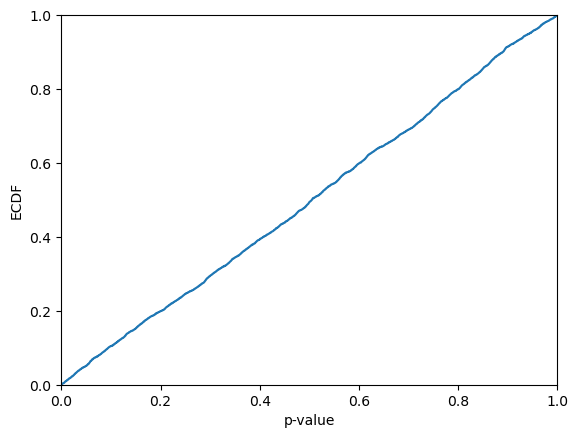

KS-test: 0.008251446500208679


In [70]:
p_values = cr_mond.predict_p(y_hat_test, y_test, bins=bins_test)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

### Investigating the prediction intervals

Let us first put all the intervals in a dictionary.

In [71]:
prediction_intervals = {
    "Std CR":intervals_std,
    "Norm CR knn dist":intervals_norm_knn_dist,
    "Norm CR knn std":intervals_norm_knn_std,
    "Norm CR knn res":intervals_norm_knn_res,
    "Norm CR var":intervals_norm_var,
    "Mond CR":intervals_mond,
}

Let us see what fraction of the intervals that contain the true targets and how large the intervals are.

In [72]:
coverages = []
mean_sizes = []
median_sizes = []

for name in prediction_intervals.keys():
    intervals = prediction_intervals[name]
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(prediction_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CR,0.9510,0.0600,0.0615
Norm CR knn dist,0.9497,0.0572,0.0469
Norm CR knn std,0.9472,0.0553,0.0440
Norm CR knn res,0.9559,0.0550,0.0435
Norm CR var,0.9511,0.0507,0.0379
Mond CR,0.9531,0.0525,0.0369
Mean,0.9513,0.0551,0.0451


Let us look at the distribution of the interval sizes.

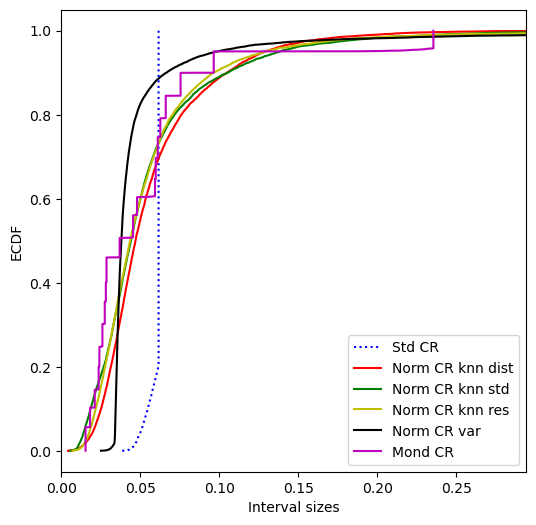

In [73]:
interval_sizes = {}
for name in prediction_intervals.keys():
    interval_sizes[name] = prediction_intervals[name][:,1] \
    - prediction_intervals[name][:,0]

plt.figure(figsize=(6,6))
plt.ylabel("ECDF")
plt.xlabel("Interval sizes")
plt.xlim(0,interval_sizes["Mond CR"].max()*1.25)

colors = ["b","r","g","y","k","m","c","orange"]

for i, name in enumerate(interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(interval_sizes[name]),
             [i/len(interval_sizes[name])
              for i in range(1,len(interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

### Evaluating the conformal regressors

Let us put the six above conformal regressors in a dictionary, together with the corresponding difficulty estimates for the test instances (if any).

In [74]:
all_cr = {
    "Std CR": (cr_std, []),
    "Norm CR knn dist": (cr_norm_knn_dist, sigmas_test_knn_dist),
    "Norm CR knn std": (cr_norm_knn_std, sigmas_test_knn_std),
    "Norm CR knn res": (cr_norm_knn_res, sigmas_test_knn_res),
    "Norm CR var" : (cr_norm_var, sigmas_test_var),
    "Mond CR": (cr_mond, sigmas_test_var),
}

Let us evaluate them using three confidence levels on the test set.
We could specify a subset of the metrics to use by the named
`metrics` argument of the `evaluate` method; here we use all, 
which is the default.

Note that the arguments `sigmas` and `bins` can always be provided,
but they will be ignored by conformal regressors not using them,
e.g., both arguments will be ignored by the standard conformal regressors.

In [75]:
confidence_levels = [0.9,0.95,0.99]

names = list(all_cr.keys())

all_results = {}

for confidence in confidence_levels:
    for name in names:
        all_results[(name,confidence)] = all_cr[name][0].evaluate(
        y_hat_test, y_test, sigmas=all_cr[name][1],
        bins=bins_test, confidence=confidence, 
        y_min=0, y_max=1)

results_df = pd.DataFrame(columns=pd.MultiIndex.from_product(
    [names,confidence_levels]), index=list(list(
    all_results.values())[0].keys()))

for key in all_results.keys():
    results_df[key] = all_results[key].values()

display(results_df.round(4))

Std CR                 Norm CR knn dist                  \
                 0.90    0.95    0.99             0.90    0.95    0.99   
error          0.0930  0.0490  0.0118           0.0976  0.0503  0.0130   
eff_mean       0.0423  0.0600  0.1093           0.0438  0.0572  0.0852   
eff_med        0.0426  0.0615  0.1131           0.0357  0.0469  0.0702   
ks_test        0.0044  0.0043  0.0044           0.3929  0.3917  0.3882   
time_fit       0.0002  0.0002  0.0002           0.0001  0.0001  0.0001   
time_evaluate  0.1740  0.1626  0.1584           0.1572  0.1559  0.1545   

              Norm CR knn std                 Norm CR knn res                  \
                         0.90    0.95    0.99            0.90    0.95    0.99   
error                  0.0968  0.0528  0.0097          0.0940  0.0441  0.0086   
eff_mean               0.0437  0.0553  0.0887          0.0423  0.0550  0.0891   
eff_med                0.0347  0.0440  0.0718          0.0334  0.0435  0.0715   
ks_test                0.0009  0.0008  0.0008          0.0437  0.0433  0.0396   
time_fit               0.0001  0.0001  0.0001          0.0001  0.0001  0.0001   
time_evaluate          0.1625  0.1645  0.1602          0.1568  0.1552  0.1535   

              Norm CR var                 Mond CR                  
                     0.90    0.95    0.99    0.90    0.95    0.99  
error              0.0973  0.0489  0.0110  0.1013  0.0469  0.0081  
eff_mean           0.0397  0.0507  0.0770  0.0414  0.0525  0.0865  
eff_med            0.0295  0.0379  0.0591  0.0298  0.0369  0.0577  
ks_test            0.0020  0.0020  0.0019  0.0086  0.0073  0.0078  
time_fit           0.0000  0.0000  0.0000  0.0003  0.0003  0.0003  
time_evaluate      0.1656  0.1671  0.1629  0.0993  0.1001  0.1033

### Semi-online conformal regressors

Similar to semi-online conformal classifiers, we may consider employing *online calibration* also for conformal regressors, i.e., continuously updating the calibration set after making each prediction. This is achieved by the methods `predict_int_online` and `predict_p_online`, and also (optionally) through the `evaluate` method. 

#### Online calibration with a fitted conformal regressor

Here we will compute p-values for the correct targets in an online fashion for some of the above fitted conformal regressors. Let us start with the standard (non-normalized) conformal regressor.

array([0.56217858, 0.10111546, 0.84690133, ..., 0.36653669, 0.654559  ,
       0.4732863 ])

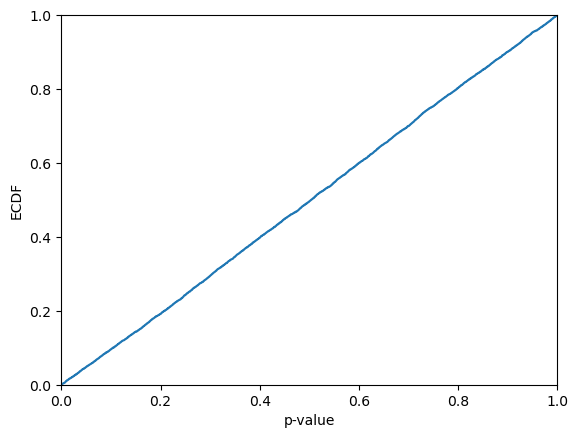

KS-test: 0.31653950301047484


In [76]:
p_values = cr_std.predict_p_online(y_hat_test, y_test)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

For the normalized conformal regressor, the non-conformity scores for the test set also involves the difficulty estimates (sigmas).

array([0.51007057, 0.04776858, 0.92387496, ..., 0.32413254, 0.61571567,
       0.39566451])

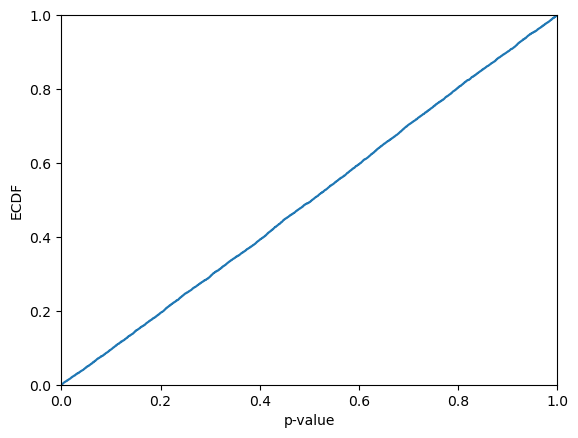

KS-test: 0.2965080903405307


In [77]:
p_values = cr_norm_var.predict_p_online(y_hat_test, y_test, 
                                        sigmas=sigmas_test_var)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

For the Mondrian conformal regressor, we need to provide the categories for the test objects:

array([0.35539022, 0.13602428, 0.96197703, ..., 0.36807299, 0.5606659 ,
       0.21427931])

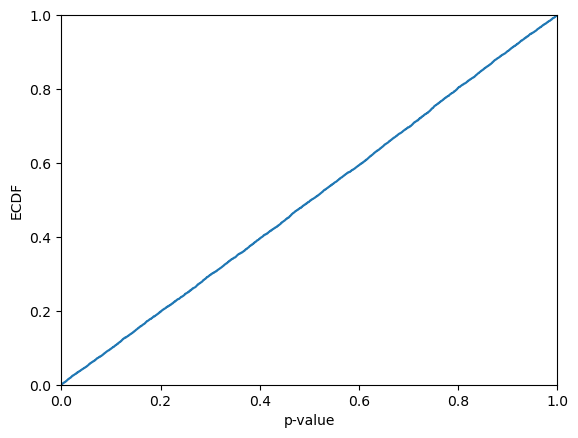

KS-test: 0.6477592899469131


In [78]:
p_values = cr_mond.predict_p_online(y_hat_test, y_test, bins=bins_test)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

Similarly, we can obtain prediction intervals using online calibration:

In [79]:
cr_std.predict_int_online(y_hat_test, y_test, y_min=0, y_max=1, confidence=0.9)

array([[0.00674634, 0.04929905],
       [0.03716232, 0.07971503],
       [0.15054483, 0.19309754],
       ...,
       [0.02297872, 0.06395071],
       [0.02318558, 0.06415757],
       [0.00777928, 0.04875127]])

In [80]:
cr_norm_var.predict_int_online(y_hat_test, y_test, sigmas=sigmas_test_var, 
                               y_min=0, y_max=1, confidence=0.9)

array([[0.01453758, 0.0415078 ],
       [0.04249699, 0.07438036],
       [0.13843426, 0.20520811],
       ...,
       [0.02851292, 0.05841651],
       [0.02995213, 0.05739103],
       [0.01497291, 0.04155764]])

In [81]:
cr_mond.predict_int_online(y_hat_test, y_test, bins=bins_test, 
                           y_min=0, y_max=1, confidence=0.9)

array([[0.01895246, 0.03709292],
       [0.03577035, 0.08110699],
       [0.13105432, 0.21258805],
       ...,
       [0.02834457, 0.05858486],
       [0.03299241, 0.05435074],
       [0.02022964, 0.0363009 ]])

By default, the test objects and labels are sequentially added to the existing calibration set, i.e., the one used when fitting the conformal regressor. We may set the `warm_start` option to `False`, if we would like to ignore the original calibration set. Note that the initial predictions tend to be very (maximally) wide, before we have a sufficiently large calibration set to allow for providing tighter intervals at the specified level of confidence.

In [82]:
cr_std.predict_int_online(y_hat_test, y_test, y_min=0, y_max=1, confidence=0.9,
                      warm_start=False)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.02309016, 0.06383927],
       [0.02329702, 0.06404613],
       [0.00789072, 0.04863983]])

In [83]:
cr_norm_var.predict_int_online(y_hat_test, y_test, sigmas=sigmas_test_var, 
                               y_min=0, y_max=1, confidence=0.9, warm_start=False)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.02853271, 0.05839672],
       [0.02997029, 0.05737287],
       [0.0149905 , 0.04154004]])

In [84]:
cr_mond.predict_int_online(y_hat_test, y_test, bins=bins_test, y_min=0, y_max=1, 
                           confidence=0.9, warm_start=False)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.02817262, 0.05875681],
       [0.03283112, 0.05451204],
       [0.02025481, 0.03627573]])

We may also evaluate the conformal regressors using online calibration, by specifying `online=True` for the `evaluate` method:

In [85]:
cr_std.evaluate(y_hat_test, y_test, confidence=0.99, y_min=0, y_max=1, 
                online=True)

{'error': 0.010363653187748678,
 'eff_mean': 0.11601639159439762,
 'eff_med': 0.1182096159999999,
 'ks_test': 0.32219030227154966,
 'time_fit': 0.00021147727966308594,
 'time_evaluate': 0.23187685012817383}

In [86]:
cr_norm_var.evaluate(y_hat_test, y_test, sigmas=sigmas_test_var, 
                     confidence=0.99, y_min=0, y_max=1, online=True)

{'error': 0.00990099009900991,
 'eff_mean': 0.07911406750028106,
 'eff_med': 0.06094932682270948,
 'ks_test': 0.30670935229608176,
 'time_fit': 4.410743713378906e-05,
 'time_evaluate': 0.23729372024536133}

In [87]:
cr_mond.evaluate(y_hat_test, y_test, bins=bins_test, confidence=0.99, 
                 y_min=0, y_max=1, online=True)

{'error': 0.008883131303784597,
 'eff_mean': 0.08176349040308119,
 'eff_med': 0.058694358557377174,
 'ks_test': 0.6773461391089948,
 'time_fit': 0.00027942657470703125,
 'time_evaluate': 0.13589119911193848}

Again, we may consider ignoring the original calibration set by setting `warm_start=False`:

In [88]:
cr_std.evaluate(y_hat_test, y_test, confidence=0.99, y_min=0, y_max=1, 
                online=True, warm_start=False)

{'error': 0.00925326177477559,
 'eff_mean': 0.13094088632287207,
 'eff_med': 0.12355990268852475,
 'ks_test': 0.320111395693632,
 'time_fit': 0.00021147727966308594,
 'time_evaluate': 0.22288060188293457}

In [89]:
cr_norm_var.evaluate(y_hat_test, y_test, sigmas=sigmas_test_var, confidence=0.99,
                     y_min=0, y_max=1, online=True, warm_start=False)

{'error': 0.008698066068289045,
 'eff_mean': 0.08954859736991394,
 'eff_med': 0.06255268206715486,
 'ks_test': 0.3056788025210102,
 'time_fit': 4.410743713378906e-05,
 'time_evaluate': 0.23671722412109375}

In [90]:
cr_mond.evaluate(y_hat_test, y_test, bins=bins_test, confidence=0.99, 
                 y_min=0, y_max=1, online=True, warm_start=False)

{'error': 0.006847413713333972,
 'eff_mean': 0.25423864642541644,
 'eff_med': 0.07076372354098351,
 'ks_test': 0.7000860320809943,
 'time_fit': 0.00027942657470703125,
 'time_evaluate': 0.13877654075622559}

#### Online calibration without an initial calibration set

Since the calibration set is incrementally extended during online calibration, we may consider starting with an empty calibration set; this allows us to use the full training set when fitting the underlying model. 

In [91]:
rf_full = RandomForestRegressor(n_jobs=-1, n_estimators=500)

rf_full.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

Let us compute non-conformity scores for the test set using the model trained on the full training set:

In [92]:
y_hat_full = rf_full.predict(X_test)

We may now create a conformal regressor, but this time without fitting a calibration set:

In [93]:
cr_full = ConformalRegressor()

We may now obtain prediction intervals while sequentially updating the calibration set:

In [94]:
cr_full.predict_int_online(y_hat_full, y_test, confidence=0.9)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.02467109, 0.06406953],
       [0.02319163, 0.06259008],
       [0.00751889, 0.04691734]])

If we provide also difficulty estimates (`sigmas`), we will obtain a normalized conformal regressor:

In [95]:
cr_full.predict_int_online(y_hat_full, y_test, sigmas=sigmas_test_var, confidence=0.9)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.02953552, 0.05920511],
       [0.02927876, 0.05650295],
       [0.01402977, 0.04040646]])

We get a Mondrian regressor by providing the categories for the test set, here by dividing the predictions into seven intervals:

In [96]:
bin_thresholds = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.5, 1.0]
bins_test = binning(rf_full.predict(X_test), bin_thresholds)

cr_full.predict_int_online(y_hat_full, y_test, bins=bins_test, confidence=0.9)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.02951927, 0.05922135],
       [0.02803982, 0.05774189],
       [0.01642939, 0.03800684]])

Let us investigate the coverage and prediction interval size for each category:

In [97]:
intervals = cr_full.predict_int_online(y_hat_full, y_test,
                                       bins=bins_test, y_min=0, y_max=1, 
                                       confidence=0.9)
number = []
coverage = []
size = []

for c in range(len(bin_thresholds)-1):
    selection = bins_test == c
    number.append(np.sum(selection))
    coverage.append(np.sum(
        (intervals[selection,0] <= y_test[selection])& \
        (y_test[selection] <= intervals[selection,1]))/np.sum(selection))
    size.append(np.sum(intervals[selection,1]-\
                       intervals[selection,0])/np.sum(selection))

df = pd.DataFrame({"Number":number, "Coverage":coverage, "Size":size})
df.round(4)

,Number,Coverage,Size
0,573,0.9110,0.0360
1,3235,0.9023,0.0248
2,2825,0.9154,0.0351
3,1929,0.8963,0.0439
4,1023,0.9150,0.0617
5,1217,0.9121,0.1363
6,5,1.0000,1.0000


We can use `predict_p_online` to get the p-values:

array([0.04433503, 0.55168219, 0.99147872, ..., 0.32671194, 0.65758918,
       0.2918815 ])

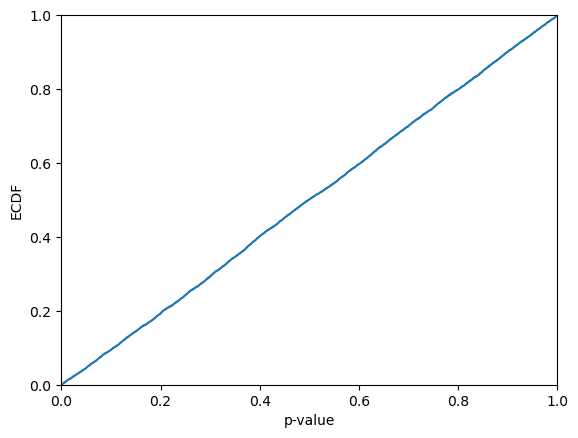

KS-test: 0.36230508215180257


In [98]:
p_values = cr_full.predict_p_online(y_hat_test, y_test, bins=bins_test)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

We may also evaluate the conformal regressor using online calibration, by specifying `online=True` for the `evaluate` method:

In [99]:
cr_full.evaluate(y_hat_full, y_test, y_min=0, y_max=1, confidence=0.9, 
                 online=True)

{'error': 0.09290274821874711,
 'eff_mean': 0.04190774164827582,
 'eff_med': 0.040597548590163374,
 'ks_test': 0.0736480025501508,
 'time_fit': None,
 'time_evaluate': 0.20582008361816406}

For Mondrian conformal regression, we just have to provide the categories:

In [100]:
cr_full.evaluate(y_hat_full, y_test, bins=bins_test, y_min=0, y_max=1, 
                 confidence=0.9, online=True)

{'error': 0.09253261774775612,
 'eff_mean': 0.04799839739221846,
 'eff_med': 0.03149373114754073,
 'ks_test': 0.15630288236588008,
 'time_fit': None,
 'time_evaluate': 0.14400410652160645}

### Out-of-bag calibration

For conformal regressors that employ learners that use bagging, like random forests, we may consider an alternative strategy to dividing the original training set into a proper training and calibration set; we may use the out-of-bag (OOB) predictions, which allow us to use the full training set for both model building and calibration. It should be noted that this strategy does not come with the theoretical validity guarantee of the above (inductive) conformal regressors, due to that calibration and test instances are not handled in exactly the same way. In practice, however, conformal regressors based on out-of-bag predictions rarely do not meet the coverage requirements.

#### Standard conformal regressors with out-of-bag calibration

Let us first generate a model from the full training set and then get the residuals using the OOB predictions; we rely on that the learner has an attribute `oob_prediction_`, which e.g. is the case for a `RandomForestRegressor` if `oob_score` is set to `True` when created.

In [101]:
learner_full = RandomForestRegressor(n_jobs=-1, n_estimators=500, 
                                     oob_score=True)

learner_full.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True)

Now we can obtain the residuals.

In [102]:
oob_predictions = learner_full.oob_prediction_

residuals_oob = y_train - oob_predictions

We may now obtain a standard conformal regressor from these OOB residuals

In [103]:
cr_std_oob = ConformalRegressor()

cr_std_oob.fit(residuals_oob)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

... and apply it using the point predictions of the full model.

In [104]:
y_hat_full = learner_full.predict(X_test)

intervals_std_oob = cr_std_oob.predict_int(y_hat_full, y_min=0, y_max=1)

display(intervals_std_oob)

array([[0.        , 0.05936269],
       [0.0294215 , 0.09067374],
       [0.13355532, 0.19480756],
       ...,
       [0.01365878, 0.07491102],
       [0.01310291, 0.07435515],
       [0.        , 0.05830365]])

#### Normalized conformal regressors with out-of-bag calibration

We may also generate normalized conformal regressors from the OOB predictions. The `DifficultyEstimator` can be used also for this purpose; for the k-nearest neighbor approaches, the difficulty of each object in the training set will be computed using a leave-one-out procedure, while for the variance-based approach the out-of-bag predictions will be employed. 

By setting `oob=True`, we inform the `fit` method that we may request difficulty estimates for the provided set of objects; these will be retrieved by not providing any objects when calling the `apply` method.

Let us start with the k-nearest neighbor approach using distances only.

In [105]:
de_knn_dist_oob = DifficultyEstimator()

de_knn_dist_oob.fit(X=X_train, scaler=True, oob=True)

display(de_knn_dist_oob)

sigmas_knn_dist_oob = de_knn_dist_oob.apply()

cr_norm_knn_dist_oob = ConformalRegressor()

cr_norm_knn_dist_oob.fit(residuals_oob, sigmas=sigmas_knn_dist_oob)

DifficultyEstimator(fitted=True, type=knn, k=25, target=none, scaler=True, beta=0.01, oob=True)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In order to apply the normalized OOB regressors to the test set, we
need to generate difficulty estimates for the latter too.

In [106]:
sigmas_test_knn_dist_oob = de_knn_dist_oob.apply(X_test)

intervals_norm_knn_dist_oob = cr_norm_knn_dist_oob.predict_int(
    y_hat_full, sigmas=sigmas_test_knn_dist_oob, y_min=0, y_max=1)

display(intervals_norm_knn_dist_oob)

array([[0.01116466, 0.04630847],
       [0.01125494, 0.10884029],
       [0.13664377, 0.19171911],
       ...,
       [0.0071363 , 0.08143349],
       [0.0277659 , 0.05969216],
       [0.00597985, 0.04937521]])

For completeness, we will illustrate the use of out-of-bag calibration for the remaining approaches too. For k-nearest neighbors with labels, we do the following:

In [107]:
de_knn_std_oob = DifficultyEstimator()

de_knn_std_oob.fit(X=X_train, y=y_train, scaler=True, oob=True)

display(de_knn_std_oob)

sigmas_knn_std_oob = de_knn_std_oob.apply()

cr_norm_knn_std_oob = ConformalRegressor()

cr_norm_knn_std_oob.fit(residuals=residuals_oob, sigmas=sigmas_knn_std_oob)

sigmas_test_knn_std_oob = de_knn_std_oob.apply(X_test)

intervals_norm_knn_std_oob = cr_norm_knn_std_oob.predict_int(
    y_hat_full, sigmas=sigmas_test_knn_std_oob, y_min=0, y_max=1)

display(intervals_norm_knn_std_oob)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=True)

array([[0.01040222, 0.04707091],
       [0.01751339, 0.10258184],
       [0.12133658, 0.2070263 ],
       ...,
       [0.02582716, 0.06274264],
       [0.03392409, 0.05353396],
       [0.01796022, 0.03739484]])

A third option is to use k-nearest neighbors with (OOB) residuals:

In [108]:
de_knn_res_oob = DifficultyEstimator()

de_knn_res_oob.fit(X=X_train, residuals=residuals_oob, scaler=True, oob=True)

display(de_knn_res_oob)

sigmas_knn_res_oob = de_knn_res_oob.apply()

cr_norm_knn_res_oob = ConformalRegressor()

cr_norm_knn_res_oob.fit(residuals_oob, sigmas=sigmas_knn_res_oob)

sigmas_test_knn_res_oob = de_knn_res_oob.apply(X_test)

intervals_norm_knn_res_oob = cr_norm_knn_res_oob.predict_int(
    y_hat_full, sigmas=sigmas_test_knn_res_oob, y_min=0, y_max=1)

display(intervals_norm_knn_res_oob)

DifficultyEstimator(fitted=True, type=knn, k=25, target=residuals, scaler=True, beta=0.01, oob=True)

array([[0.01476125, 0.04271188],
       [0.03525929, 0.08483595],
       [0.11120957, 0.21715331],
       ...,
       [0.03526134, 0.05330845],
       [0.02774373, 0.05971432],
       [0.01962453, 0.03573053]])

A fourth and final option for the normalized conformal regressors is to use variance as a difficulty estimate. We then leave labels and residuals out, but provide an (ensemble) learner. In contrast to when `oob=False`, we are here required to provide the (full) training set, from which the variance of the out-of-bag predictions will be computed. When applied to the test set, the full ensemble model will not be used to obtain the difficulty estimates, but instead a subset of the constituent models is used, following what could be seen as post hoc assignment of each test instance to a bag.      

In [109]:
de_var_oob = DifficultyEstimator()

de_var_oob.fit(X=X_train, learner=learner_full, scaler=True, oob=True)

display(de_var_oob)

sigmas_var_oob = de_var_oob.apply()

cr_norm_var_oob = ConformalRegressor()

cr_norm_var_oob.fit(residuals_oob, sigmas=sigmas_var_oob)

sigmas_test_var_oob = de_var_oob.apply(X_test)

intervals_norm_var_oob = cr_norm_var_oob.predict_int(y_hat_full, 
                                                     sigmas=sigmas_test_var_oob, 
                                                     y_min=0, y_max=1)

display(intervals_norm_var_oob)

DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=True)

array([[0.01105193, 0.0464212 ],
       [0.03974938, 0.08034585],
       [0.12282223, 0.20554065],
       ...,
       [0.02345883, 0.06511097],
       [0.0256265 , 0.06183156],
       [0.01017128, 0.04518377]])

#### Mondrian conformal regressors with out-of-bag calibration

We may form the categories using the difficulty estimates obtained from the OOB predictions. We here consider the difficulty estimates produced by the fourth above option (using variance) only. 

In [110]:
bins_oob, bin_thresholds_oob = binning(sigmas_var_oob, bins=20)

cr_mond_oob = ConformalRegressor()

cr_mond_oob.fit(residuals=residuals_oob, bins=bins_oob)

ConformalRegressor(fitted=True, normalized=False, mondrian=True)

... and assign the categories for the test instances, ...

In [111]:
bins_test_oob = binning(sigmas_test_var_oob, bins=bin_thresholds_oob)

... and finally generate the prediction intervals.

In [112]:
intervals_mond_oob = cr_mond_oob.predict_int(y_hat_full,
                                         bins=bins_test_oob,
                                         y_min=0, y_max=1)

display(intervals_mond_oob)

array([[0.0184766 , 0.03899653],
       [0.03784055, 0.08225468],
       [0.11179549, 0.21656739],
       ...,
       [0.02166709, 0.0669027 ],
       [0.03048874, 0.05696931],
       [0.01912813, 0.03622693]])

### Investigating the OOB prediction intervals

In [113]:
prediction_intervals = {
    "Std CR OOB":intervals_std_oob,
    "Norm CR knn dist OOB":intervals_norm_knn_dist_oob,
    "Norm CR knn std OOB":intervals_norm_knn_std_oob,
    "Norm CR knn res OOB":intervals_norm_knn_res_oob,
    "Norm CR var OOB":intervals_norm_var_oob,
    "Mond CR OOB":intervals_mond_oob,
}

Let us see what fraction of the intervals that contain the true targets and how large the intervals are.

In [114]:
coverages = []
mean_sizes = []
median_sizes = []

for name in prediction_intervals.keys():
    intervals = prediction_intervals[name]
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(prediction_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CR OOB,0.9512,0.0598,0.0613
Norm CR knn dist OOB,0.9493,0.0561,0.0461
Norm CR knn std OOB,0.9531,0.0575,0.0452
Norm CR knn res OOB,0.9543,0.0535,0.0419
Norm CR var OOB,0.9506,0.0490,0.0380
Mond CR OOB,0.9498,0.0500,0.0366
Mean,0.9514,0.0543,0.0448


Let us look at the distribution of the interval sizes.

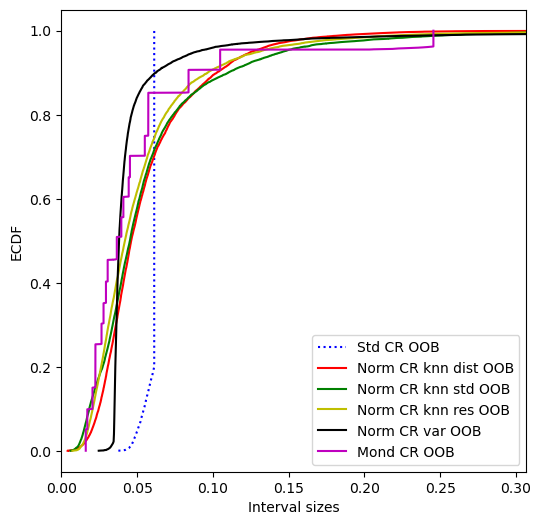

In [115]:
interval_sizes = {}
for name in prediction_intervals.keys():
    interval_sizes[name] = prediction_intervals[name][:,1] \
    - prediction_intervals[name][:,0]

plt.figure(figsize=(6,6))
plt.ylabel("ECDF")
plt.xlabel("Interval sizes")
plt.xlim(0,interval_sizes["Mond CR OOB"].max()*1.25)

colors = ["b","r","g","y","k","m","c","orange"]

for i, name in enumerate(interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(interval_sizes[name]),
             [i/len(interval_sizes[name])
              for i in range(1,len(interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

## Conformal Predictive Systems (CPS)

### Creating and fitting CPS

Let us create and fit standard and normalized conformal predictive systems, using the residuals from the calibration set (as obtained in the previous section), as well two conformal predictive systems using out-of-bag residuals; with and without normalization. As can be seen, the input for fitting conformal predictive systems is on the same format as for the conformal regressors.

In [116]:
cps_std = ConformalPredictiveSystem().fit(residuals_cal)

cps_norm = ConformalPredictiveSystem().fit(residuals_cal,
                                           sigmas=sigmas_cal_var)

cps_std_oob = ConformalPredictiveSystem().fit(residuals_oob)

cps_norm_oob = ConformalPredictiveSystem().fit(residuals_oob, 
                                               sigmas=sigmas_var_oob)

Let us also create some Mondrian CPS, but in contrast to the Mondrian conformal regressors above, we here form the categories through binning of the predictions rather than binning of the difficulty estimates. We may use the latter, i.e., the sigmas, to obtain a normalized CPS for each category (bin).

In [117]:
bins_cal, bin_thresholds = binning(y_hat_cal, bins=5)

cps_mond_std = ConformalPredictiveSystem().fit(residuals_cal,
                                               bins=bins_cal)

cps_mond_norm = ConformalPredictiveSystem().fit(residuals_cal,
                                                sigmas=sigmas_cal_var,
                                                bins=bins_cal)


bins_oob, bin_thresholds_oob = binning(oob_predictions, bins=5)

cps_mond_std_oob = ConformalPredictiveSystem().fit(residuals_oob,
                                                   bins=bins_oob)

cps_mond_norm_oob = ConformalPredictiveSystem().fit(residuals_oob,
                                                    sigmas=sigmas_var_oob,
                                                    bins=bins_oob)

### Making predictions

For the normalized approaches, we already have the difficulty estimates which are needed for the test instances. 
For the Mondrian approaches, we also need to assign the new categories to the test instances.

In [118]:
bins_test = binning(y_hat_test, bins=bin_thresholds)

bins_test_oob = binning(y_hat_full, bins=bin_thresholds_oob)

The `predict_p` and `predict_int` methods work as for conformal regressors, i.e., to get p-values and prediction intervals. There are also some methods that are specific to conformal predictive systems; `predict_percentiles` and `predict_cpds` that are used for obtaining percentiles and conformal predictive distributions, respectively. In addition, we may employ the `predict` method, for which the output will depend on how we specify the input and which can be used for getting all of the above by just one call.

Here we will obtain the p-values from `cps_mond_norm` for the true targets of the test set:

In [119]:
p_values = cps_mond_norm.predict_p(y_hat_test, y_test, sigmas=sigmas_test_var,
                                   bins=bins_test, seed=123)

display(p_values)

array([0.17840677, 0.03564906, 0.47458829, ..., 0.85454026, 0.35707334,
       0.87674664])

Let us take a look at how the p-values are distributed. From the visual inspection they may appear be approximaly uniformly distributed; this is however not guaranteed, since the p-values are not independent (see further below for semi-online conformal predictive systems, for which this indeed holds). It is hence not very surprising if the Kolmogorov-Smirnov test allows us to reject that the p-values are sampled from a uniform distribution. 

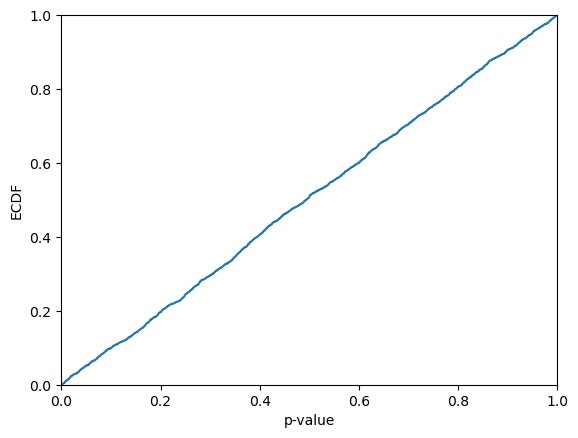

KS-test: 0.04849129053712553


In [120]:
plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

We can get the same result through `predict` in the following way (since `smoothing` is enabled by default, we need to set the `seed` to get identical results): 

In [121]:
p_values = cps_mond_norm.predict(y_hat_test,
                                 sigmas=sigmas_test_var,
                                 bins=bins_test,
                                 y=y_test, seed=123)

display(p_values)

array([0.17840677, 0.03564906, 0.47458829, ..., 0.85454026, 0.35707334,
       0.87674664])

We can also request non-smoothed p-values, which are computed deterministically (a `seed` is hence not required to replicate the output): 

In [122]:
p_values = cps_mond_norm.predict_p(y_hat_test, y_test, sigmas_test_var,
                                   bins_test, smoothing=False)

display(p_values)

array([0.17896679, 0.03696858, 0.47601476, ..., 0.85582255, 0.35859519,
       0.87822878])

We can get the same result through `predict` in the following way: 

In [123]:
p_values = cps_mond_norm.predict(y_hat_test,
                                 sigmas=sigmas_test_var,
                                 bins=bins_test,
                                 y=y_test, smoothing=False)

display(p_values)

array([0.17896679, 0.03696858, 0.47601476, ..., 0.85582255, 0.35859519,
       0.87822878])

If we instead would like to get threshold values, such that the probability for the true target is less than the threshold for each test instance, we may request these through `predict_percentiles` or by providing `lower_percentiles` and/or `upper_percentiles` as input to the `predict` method. These denote (one or more) percentiles for which a lower (upper) value will be selected in case a percentile lies between two values (similar to `interpolation="lower"` and `interpolation="higher"` in `numpy.percentile`).

Here we will obtain the lowest values from `cps_mond_norm`, such that the probability for the target values being less than these is at least 50%, first using `predict_percentiles`:

In [124]:
thresholds = cps_mond_norm.predict_percentiles(y_hat_test, sigmas_test_var,
                                               bins_test, higher_percentiles=50)

display(thresholds)

array([0.02829887, 0.05789694, 0.17152393, ..., 0.04279352, 0.04305571,
       0.02853928])

Again, the same result can be obtained using the `predict` method: 

In [125]:
thresholds = cps_mond_norm.predict(y_hat_test, sigmas_test_var,
                                   bins_test, higher_percentiles=50)

display(thresholds)

array([0.02829887, 0.05789694, 0.17152393, ..., 0.04279352, 0.04305571,
       0.02853928])

We can also specify both target values and percentiles for the `predict` method; the resulting p-values will be returned in the first column, while any values corresponding to the lower percentiles will be included in the subsequent columns, followed by columns containing the values corresponding to the higher percentiles. The following call hence results in an array with five columns:

In [126]:
results = cps_mond_norm.predict(y_hat_test,
                                sigmas=sigmas_test_var,
                                bins=bins_test,
                                y=y_test,
                                lower_percentiles=[2.5, 5],
                                higher_percentiles=[95, 97.5])

display(results)

array([[0.17783429, 0.0164767 , 0.0186728 , 0.03708165, 0.04041966],
       [0.03690463, 0.03569243, 0.0388287 , 0.07749237, 0.08472576],
       [0.47481815, 0.12688174, 0.13695332, 0.2199475 , 0.2326246 ],
       ...,
       [0.85546363, 0.02568507, 0.02853342, 0.05647774, 0.0597404 ],
       [0.35737255, 0.02735735, 0.02997094, 0.05561205, 0.0586058 ],
       [0.87750888, 0.01680985, 0.01898872, 0.03725317, 0.04056499]])

In addition to p-values and threshold values, we can request that the conformal predictive system returns the full conformal predictive distribution (CPD) for each test instance, as defined by the threshold values, either by the `predict_cpds` method or by setting `return_cpds=True` for the `predict` method . The format of the distributions vary with the type of conformal predictive system; for a standard and normalized CPS, the output is an array with a row for each test instance and a column for each calibration instance (residual), while for a Mondrian CPS, the default output is a vector containing one CPD per test instance (since the number of values may vary between categories). If the desired output instead is an array of distributions per category, where all distributions in a category have the same number of columns, which in turn depends on the number of calibration instances in the corresponding category, then `cpds_by_bins=True` may be specified (for both methods). In case `return_cpds=True` is specified together with `y`, `lower_percentiles` or `higher_percentiles`, the output of `predict` will be a pair, with the first element holding the results of the above type and the second element will contain the CPDs. 

For the above Mondrian CPS, the following call to `predict_cpds` will result in a vector of distributions, with one element for each test instance.

In [127]:
cpds = cps_mond_norm.predict_cpds(y_hat_test, sigmas_test_var, bins_test)

print(f"No. of test instances: {len(y_hat_test)}")
print(f"Shape of cpds: {cpds.shape}")

No. of test instances: 10807
Shape of cpds: (10807,)


The same result can be obtained with the following call to `predict`:

In [128]:
cpds = cps_mond_norm.predict(y_hat_test,
                             sigmas=sigmas_test_var,
                             bins=bins_test,
                             return_cpds=True)

print(f"No. of test instances: {len(y_hat_test)}")
print(f"Shape of cpds: {cpds.shape}")

No. of test instances: 10807
Shape of cpds: (10807,)


If we instead would prefer to represent these distributions by one array per category, we set `cpds_by_bins=True`, noting that it will be a bit trickier to associate a test instance to a specific distribution.  

In [129]:
cpds = cps_mond_norm.predict_cpds(y_hat_test, sigmas_test_var, bins_test,
                                  cpds_by_bins=True)

for i, cpd in enumerate(cpds):
    print(f"bin {i}: {cpd.shape[0]} test instances, {cpd.shape[1]} threshold values")

print(f"No. of test instances: {sum([c.shape[0] for c in cpds])}")

bin 0: 2117 test instances, 541 threshold values
bin 1: 2140 test instances, 540 threshold values
bin 2: 2104 test instances, 540 threshold values
bin 3: 2240 test instances, 540 threshold values
bin 4: 2206 test instances, 541 threshold values
No. of test instances: 10807


The same result can be obtained with the following call to predict:

In [130]:
cpds = cps_mond_norm.predict(y_hat_test,
                             sigmas=sigmas_test_var,
                             bins=bins_test,
                             return_cpds=True, 
                             cpds_by_bins=True)

for i, cpd in enumerate(cpds):
    print(f"bin {i}: {cpd.shape[0]} test instances, {cpd.shape[1]} threshold values")

print(f"No. of test instances: {sum([c.shape[0] for c in cpds])}")

bin 0: 2117 test instances, 541 threshold values
bin 1: 2140 test instances, 540 threshold values
bin 2: 2104 test instances, 540 threshold values
bin 3: 2240 test instances, 540 threshold values
bin 4: 2206 test instances, 541 threshold values
No. of test instances: 10807


We may also plot the conformal predictive distribution for some test object. In case the calibration set is very large, you may consider plotting an approximation of the full distribution by using a grid of values for `lower_percentiles` or `higher_percentiles`, instead of setting `return_cpds=True`. For the Mondrian CPS, the size of the calibration set for each bin is reasonable in this case, so we may just use the distributions directly.

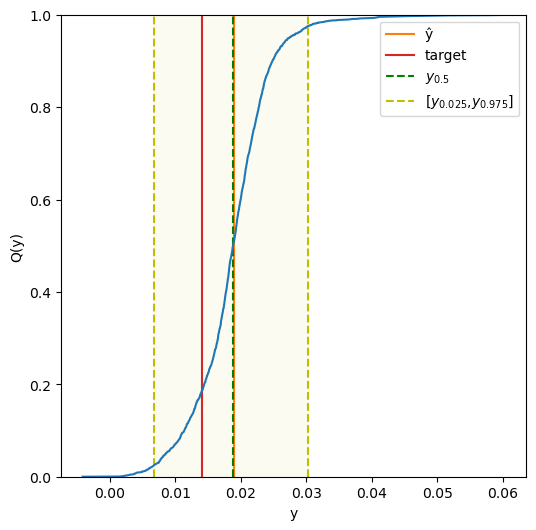

In [131]:
cpds = cps_mond_norm_oob.predict(y_hat_full,
                                 bins=bins_test_oob,
                                 sigmas=sigmas_test_var_oob,
                                 return_cpds=True)

test_index = np.random.randint(len(y_hat_full)) # A test object is randomly selected
cpd = cpds[test_index]

p = np.array([i/len(cpd) for i in range(len(cpd))])

lower_index = np.where(p<=0.025)[0][-1]
mid_index = np.where(p>=0.50)[0][0]
upper_index = np.where(p>=0.975)[0][0]

low_percentile = cpd[lower_index]
median = cpd[mid_index]
high_percentile = cpd[upper_index]

plt.figure(figsize=(6,6))
plt.plot([y_hat_full[test_index],y_hat_full[test_index]],[0,1], color="tab:orange")
plt.plot([y_test[test_index],y_test[test_index]],[0,1], color="tab:red")
plt.xlabel("y")
plt.ylabel("Q(y)")
plt.ylim(0,1)

plt.plot([median,median],[0,1],"g--")
plt.plot([low_percentile,low_percentile],[0,1],"y--")
plt.legend(["ŷ","target","$y_{0.5}$","[$y_{0.025}$,$y_{0.975}$]"])
plt.plot([high_percentile,high_percentile],[0,1],"y--")
plt.plot(cpd,p, color="tab:blue")
rectangle = plt.Rectangle((low_percentile,0),
                          abs(high_percentile-low_percentile),1, color="y", 
                          alpha=0.05)
plt.gca().add_patch(rectangle)
plt.show()

### Investigating the coverage and size of extracted prediction intervals

Let us investigate the extracted prediction intervals at the 95% confidence level. 
This is done by a specifying percentiles corresponding to the interval endpoints.

In [132]:
all_cps = {"Std CPS":cps_std,
           "Std OOB CPS":cps_std_oob,
           "Norm CPS":cps_norm,
           "Norm OOB CPS":cps_norm_oob,
           "Mond CPS":cps_mond_std,
           "Mond OOB CPS":cps_mond_std_oob,
           "Mond norm CPS":cps_mond_norm,
           "Mond norm OOB CPS":cps_mond_norm_oob
          }

all_cps_intervals = {}

coverages = []
mean_sizes = []
median_sizes = []

for name in all_cps.keys():
    if "OOB" in name:
        intervals = all_cps[name].predict(y_hat_full, 
                                          sigmas=sigmas_test_var_oob, 
                                          bins=bins_test_oob,
                                          lower_percentiles=2.5, 
                                          higher_percentiles=97.5,
                                          y_min=0, y_max=1)
    else:
        intervals = all_cps[name].predict(y_hat_test, 
                                          sigmas=sigmas_test_var, 
                                          bins=bins_test,
                                          lower_percentiles=2.5, 
                                          higher_percentiles=97.5,
                                          y_min=0, y_max=1)
    all_cps_intervals[name] = intervals
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(all_cps_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CPS,0.9541,0.0623,0.0635
Std OOB CPS,0.9528,0.0615,0.0626
Norm CPS,0.9531,0.0523,0.0391
Norm OOB CPS,0.9497,0.0497,0.0385
Mond CPS,0.9528,0.0615,0.0359
Mond OOB CPS,0.9499,0.0561,0.0398
Mond norm CPS,0.9490,0.0532,0.0351
Mond norm OOB CPS,0.9522,0.0517,0.0374
Mean,0.9517,0.0560,0.0440


### Investigating the distributions of extracted prediction intervals

Let us take a look at the distribution of the interval sizes.

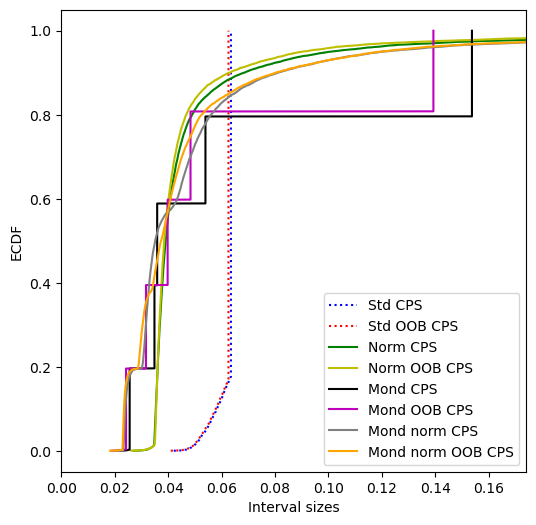

In [133]:
cps_interval_sizes = {}

for name in all_cps_intervals.keys():
    cps_interval_sizes[name] = \
    all_cps_intervals[name][:,1] - all_cps_intervals[name][:,0]

plt.figure(figsize=(6,6))
plt.ylabel("ECDF")
plt.xlabel("Interval sizes")
plt.xlim(0,cps_interval_sizes["Mond OOB CPS"].max()*1.25)

colors = ["b","r","g","y","k","m", "gray", "orange"]

for i, name in enumerate(cps_interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(cps_interval_sizes[name]),
             [i/len(cps_interval_sizes[name])
              for i in range(1,len(cps_interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

### Extracting medians

Let us take a look at the medians; they can be derived using either lower or higher interpolation,
but ideally the differences should be small.

In [134]:
all_cps_medians = {}

for name in all_cps.keys():
    if "OOB" in name:
        medians = all_cps[name].predict(y_hat_full, 
                                        sigmas=sigmas_test_var_oob, 
                                        bins=bins_test_oob,
                                        lower_percentiles=50, 
                                        higher_percentiles=50)
    else:
        medians = all_cps[name].predict(y_hat_test, 
                                        sigmas=sigmas_test_var, 
                                        bins=bins_test,
                                        lower_percentiles=50, 
                                        higher_percentiles=50)
    all_cps_medians[name] = medians
    print(name)
    print("\tMean difference of the medians:    {:.6f}".format((medians[:,1]-medians[:,0]).mean()))
    print("\tLargest difference of the medians: {:.6f}".format((medians[:,1]-medians[:,0]).max()))

Std CPS
	Mean difference of the medians:    0.000001
	Largest difference of the medians: 0.000001
Std OOB CPS
	Mean difference of the medians:    0.000000
	Largest difference of the medians: 0.000000
Norm CPS
	Mean difference of the medians:    0.000006
	Largest difference of the medians: 0.000393
Norm OOB CPS
	Mean difference of the medians:    0.000003
	Largest difference of the medians: 0.000203
Mond CPS
	Mean difference of the medians:    0.000074
	Largest difference of the medians: 0.000230
Mond OOB CPS
	Mean difference of the medians:    0.000001
	Largest difference of the medians: 0.000007
Mond norm CPS
	Mean difference of the medians:    0.000092
	Largest difference of the medians: 0.001047
Mond norm OOB CPS
	Mean difference of the medians:    0.000002
	Largest difference of the medians: 0.000011


### Another view of the medians and prediction intervals

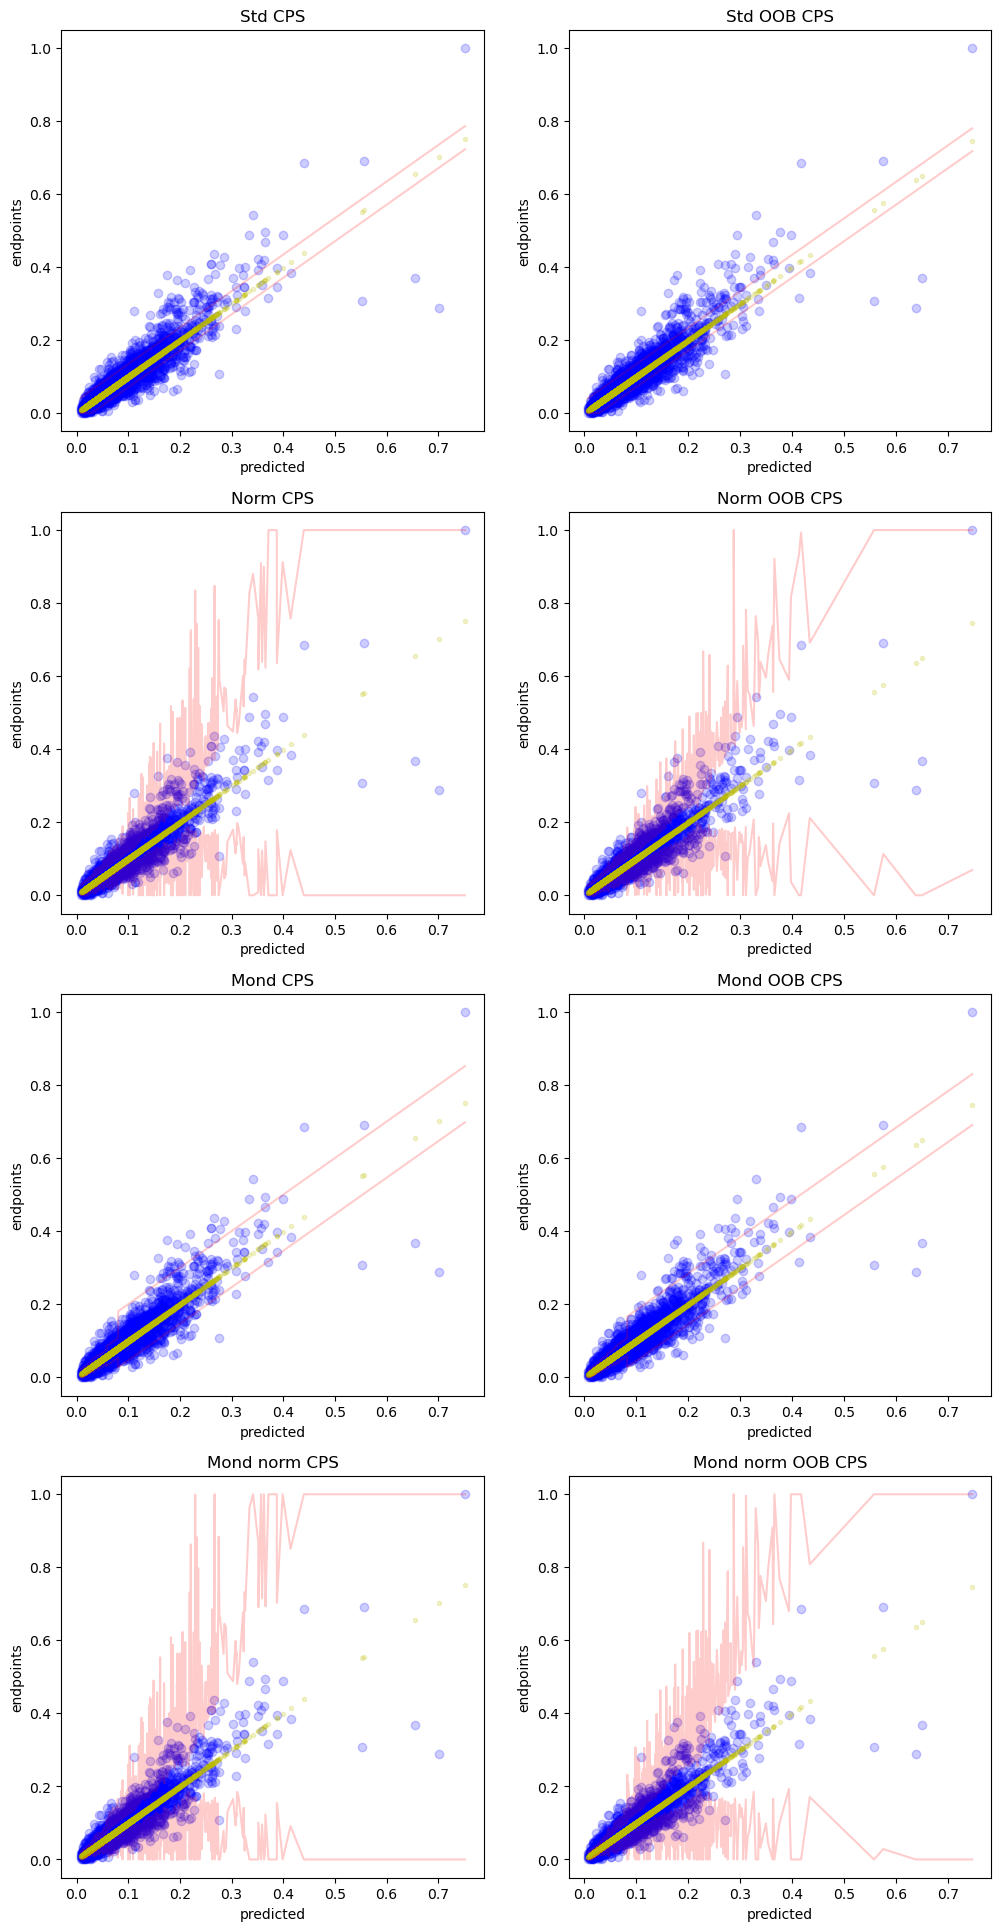

In [135]:
plt.subplots(len(all_cps_intervals.keys())//2,2,figsize=(12,24))

sorted_prop_indexes = np.argsort(y_hat_test) 

sorted_full_indexes = np.argsort(y_hat_full) 

alpha=0.2

for i, name in enumerate(all_cps_intervals.keys()):

    plt.subplot(len(all_cps_intervals.keys())//2,2,i+1)
    if "OOB" in name:
        indexes = sorted_full_indexes
        y_hat_ = y_hat_full
    else:
        indexes = sorted_prop_indexes
        y_hat_ = y_hat_test

    plt.title(name)
    plt.plot(y_hat_[indexes], all_cps_intervals[name][indexes,0], 
             color="r", alpha=alpha)
    plt.plot(y_hat_[indexes], all_cps_intervals[name][indexes,1], 
             color="r", alpha=alpha)
    plt.scatter(y_hat_[indexes],y_test[indexes],
                color="b", marker="o", alpha=alpha)
    plt.scatter(y_hat_[indexes],y_hat_[indexes],
                color="y", marker=".", alpha=alpha)
    plt.xlabel("predicted")
    plt.ylabel("endpoints")

plt.show()

### Evaluating the CPS using a test set

Let us evaluate the generated CPS using three confidence levels on the test set.
We could specify a subset of the metrics to use by the
`metrics` parameter of the `evaluate` method; here we use all metrics, 
which is the default

Note that values for the parameters `sigmas` and `bins` can always be provided,
but they will be ignored by CPS that have not been fitted with such values,
e.g., both arguments will be ignored by the standard CPS.

Note that CRPS takes some time to compute, in particular when the CPS have been fitted with 
larger calibration sets.

In [136]:
confidence_levels = [0.9,0.95,0.99]

names = np.array(list(all_cps.keys()))

first_set = names[["OOB" not in name for name in names]]
second_set = names[["OOB" in name for name in names]]

for methods in [first_set, second_set]:
    all_cps_results = {}
    for confidence in confidence_levels:
        for name in methods:
            if "OOB" in name:
                all_cps_results[(name,confidence)] = all_cps[name].evaluate(
                    y_hat_full, y_test, sigmas=sigmas_test_var_oob, 
                    bins=bins_test_oob, confidence=confidence, 
                    y_min=0, y_max=1)
            else:
                all_cps_results[(name,confidence)] =  all_cps[name].evaluate(
                    y_hat_test, y_test, sigmas=sigmas_test_var, 
                    bins=bins_test, confidence=confidence, y_min=0, y_max=1)

    cps_results_df = pd.DataFrame(columns=pd.MultiIndex.from_product(
        [methods,confidence_levels]), index=list(list(
        all_cps_results.values())[0].keys()))

    for key in all_cps_results.keys():
        cps_results_df[key] = all_cps_results[key].values()

    display(cps_results_df.round(4))

Std CPS                 Norm CPS                 Mond CPS  \
                 0.90    0.95    0.99     0.90    0.95    0.99     0.90   
error          0.0929  0.0459  0.0090   0.0968  0.0469  0.0086   0.0959   
eff_mean       0.0426  0.0623  0.1439   0.0401  0.0523  0.0799   0.0428   
eff_med        0.0428  0.0635  0.1515   0.0298  0.0391  0.0608   0.0289   
time_fit       0.0004  0.0004  0.0004   0.0001  0.0001  0.0001   0.0001   
CRPS           0.0073  0.0073  0.0073   0.0068  0.0068  0.0068   0.0070   
ks_test        0.0593  0.0632  0.0600   0.0594  0.0584  0.0590   0.0404   
time_evaluate  0.5771  0.5394  0.5437   0.5962  0.6529  0.6288   0.3553   

                              Mond norm CPS                  
                 0.95    0.99          0.90    0.95    0.99  
error          0.0472  0.0084        0.0978  0.0510  0.0058  
eff_mean       0.0615  0.1000        0.0419  0.0532  0.0892  
eff_med        0.0359  0.0743        0.0279  0.0351  0.0683  
time_fit       0.0001  0.0001        0.0002  0.0002  0.0002  
CRPS           0.0070  0.0070        0.0067  0.0067  0.0067  
ks_test        0.0513  0.0482        0.0494  0.0497  0.0435  
time_evaluate  0.3668  0.3577        0.4183  0.4165  0.4120

Std OOB CPS                 Norm OOB CPS                  \
                     0.90    0.95    0.99         0.90    0.95    0.99   
error              0.0924  0.0472  0.0099       0.1002  0.0503  0.0098   
eff_mean           0.0417  0.0615  0.1297       0.0383  0.0497  0.0787   
eff_med            0.0419  0.0626  0.1363       0.0296  0.0385  0.0617   
time_fit           0.0003  0.0003  0.0003       0.0003  0.0003  0.0003   
CRPS               0.0072  0.0072  0.0072       0.0067  0.0067  0.0067   
ks_test            0.0167  0.0170  0.0173       0.0324  0.0320  0.0320   
time_evaluate      1.3735  1.3820  1.1888       1.2982  1.3066  1.3219   

              Mond OOB CPS                 Mond norm OOB CPS                  
                      0.90    0.95    0.99              0.90    0.95    0.99  
error               0.0991  0.0501  0.0102            0.0954  0.0478  0.0094  
eff_mean            0.0415  0.0561  0.0992            0.0410  0.0517  0.0818  
eff_med             0.0297  0.0398  0.0728            0.0290  0.0374  0.0628  
time_fit            0.0004  0.0004  0.0004            0.0005  0.0005  0.0005  
CRPS                0.0069  0.0069  0.0069            0.0066  0.0066  0.0066  
ks_test             0.1432  0.1364  0.1413            0.3029  0.3014  0.3097  
time_evaluate       0.4761  0.4721  0.4631            0.5785  0.5487  0.5568

### Semi-online conformal predictive systems

Similar to semi-online conformal classifiers and regressors, we may consider employing *online calibration* also for conformal predictive systems, i.e., continuously updating the calibration set after making each prediction. This is achieved by the methods `predict_p_online`, `predict_int_online`, `predict_percentiles_online` and `predict_cpds_online`, and also (optionally) through the `evaluate` method.

#### Online calibration with a fitted conformal predictive system

Here we will compute p-values for the correct targets in an online fashion for some of the above fitted conformal predictive systems. Let us start with the standard (non-normalized) conformal predictive system.

array([0.69534626, 0.95037766, 0.55444929, ..., 0.17077673, 0.64859631,
       0.21884237])

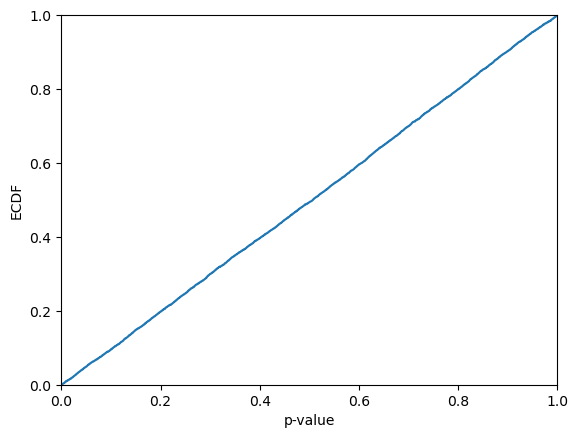

KS-test: 0.5776079428081664


In [137]:
p_values = cps_std.predict_p_online(y_hat_test, y_test)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

For the normalized conformal predictive system, the non-conformity scores for the test set also involves the difficulty estimates (sigmas).

array([0.72709781, 0.98226554, 0.51683416, ..., 0.15432702, 0.67074357,
       0.18625108])

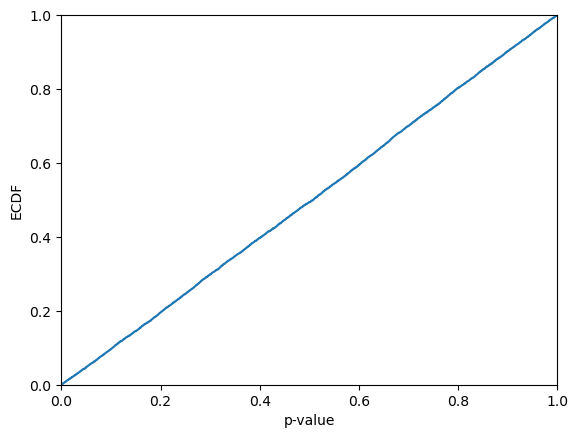

KS-test: 0.5376685400683153


In [138]:
p_values = cps_norm.predict_p_online(y_hat_test, y_test, 
                                     sigmas=sigmas_test_var)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

For the (non-normalized) Mondrian conformal predictive system, we need to provide the categories for the test objects:

array([0.81699635, 0.94144376, 0.52768858, ..., 0.14964119, 0.64844946,
       0.10773542])

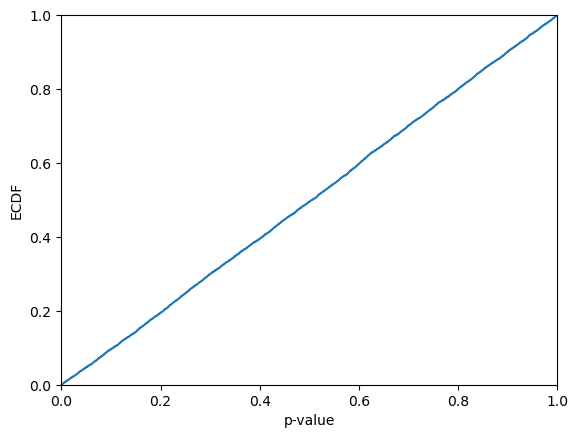

KS-test: 0.5667301018659305


In [139]:
p_values = cps_mond_std.predict_p_online(y_hat_test, y_test, 
                                         bins=bins_test)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

For the normalized Mondrian conformal predictive system, we need to provide both difficulty estimates and Mondrian categories for the test objects:

array([0.82148739, 0.96426672, 0.52556784, ..., 0.15105822, 0.66145534,
       0.10293294])

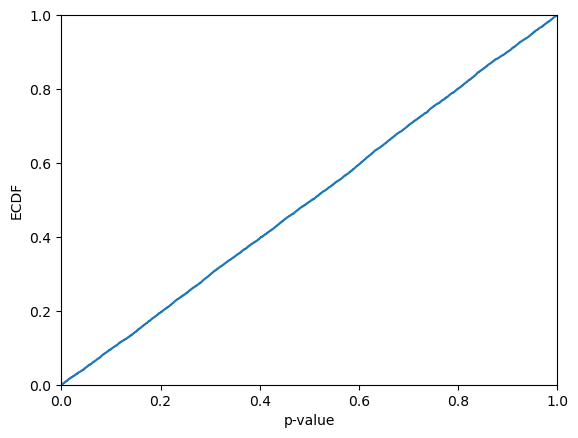

KS-test: 0.5927671590495831


In [140]:
p_values = cps_mond_norm.predict_p_online(y_hat_test, y_test, 
                                          sigmas=sigmas_test_var, 
                                          bins=bins_test)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

Similarly, we can obtain prediction intervals using online calibration:

In [141]:
cps_std.predict_int_online(y_hat_test, y_test, 
                           y_min=0, y_max=1, confidence=0.9)

array([[0.00701302, 0.04982439],
       [0.037429  , 0.08024037],
       [0.15075956, 0.19362289],
       ...,
       [0.02376279, 0.06525427],
       [0.02396965, 0.06546113],
       [0.00856334, 0.05005483]])

In [142]:
cps_norm.predict_int_online(y_hat_test, y_test, 
                            sigmas=sigmas_test_var, 
                            y_min=0, y_max=1, confidence=0.9)

array([[0.01508315, 0.04232715],
       [0.04314194, 0.07534897],
       [0.13977239, 0.20713064],
       ...,
       [0.02894676, 0.05897662],
       [0.03035021, 0.05790497],
       [0.0153586 , 0.04205558]])

In [143]:
cps_mond_std.predict_int_online(y_hat_test, y_test, 
                                bins=bins_test, 
                                y_min=0, y_max=1, confidence=0.9)

array([[0.01844149, 0.03703253],
       [0.03612738, 0.07865149],
       [0.12866898, 0.22484594],
       ...,
       [0.02839071, 0.05798011],
       [0.02859757, 0.05818698],
       [0.01780104, 0.03653765]])

In [144]:
cps_mond_norm.predict_int_online(y_hat_test, y_test, 
                                 sigmas=sigmas_test_var, bins=bins_test, 
                                 y_min=0, y_max=1, confidence=0.9)

array([[0.0186728 , 0.03708165],
       [0.0388287 , 0.07749237],
       [0.13695332, 0.2199475 ],
       ...,
       [0.02922392, 0.05698347],
       [0.03060453, 0.0560761 ],
       [0.01817478, 0.03617991]])

We can also get (lower and higher) percentiles using online calibration:

In [145]:
cps_std.predict_percentiles_online(y_hat_test, y_test, 
                                   lower_percentiles = [2.5, 25],
                                   higher_percentiles = [50, 75, 97.5],
                                   y_min=0, y_max=1)

array([[0.        , 0.02211605, 0.02766377, 0.03273211, 0.06238662],
       [0.02930072, 0.05253486, 0.05807882, 0.06313249, 0.0928026 ],
       [0.14268324, 0.16591454, 0.17146133, 0.17651501, 0.20618511],
       ...,
       [0.01572193, 0.03763537, 0.04297897, 0.04813352, 0.07752746],
       [0.01592879, 0.03784473, 0.04318583, 0.04834039, 0.07773432],
       [0.00052249, 0.02243842, 0.02777952, 0.03293408, 0.06232802]])

In [146]:
cps_norm.predict_percentiles_online(y_hat_test, y_test, 
                                    sigmas=sigmas_test_var, 
                                    lower_percentiles = [2.5, 25],
                                    higher_percentiles = [50, 75, 97.5],
                                    y_min=0, y_max=1)

array([[0.01164158, 0.02317819, 0.02769849, 0.0321323 , 0.04740387],
       [0.03907342, 0.05272599, 0.05805036, 0.06328477, 0.08135051],
       [0.13119081, 0.1598629 , 0.17101036, 0.18194006, 0.21966212],
       ...,
       [0.02559919, 0.03809131, 0.0429934 , 0.04795689, 0.06491383],
       [0.02727855, 0.03874152, 0.04323911, 0.0477935 , 0.06335283],
       [0.01238256, 0.02348869, 0.02784626, 0.03225889, 0.04733385]])

In [147]:
cps_mond_std.predict_percentiles_online(y_hat_test, y_test, 
                                        bins=bins_test, 
                                        lower_percentiles = [2.5, 25],
                                        higher_percentiles = [50, 75, 97.5],
                                        y_min=0, y_max=1)

array([[0.01601938, 0.02468636, 0.0282985 , 0.03136821, 0.04158456],
       [0.03188702, 0.05138772, 0.05785784, 0.06505169, 0.08583971],
       [0.11863259, 0.1582804 , 0.17157851, 0.18441603, 0.27241047],
       ...,
       [0.0247801 , 0.0378353 , 0.04284991, 0.04804024, 0.06189022],
       [0.02498696, 0.03804706, 0.04305677, 0.0482471 , 0.06209708],
       [0.01524904, 0.02475298, 0.028164  , 0.03097318, 0.03959056]])

In [148]:
cps_mond_norm.predict_percentiles_online(y_hat_test, y_test,
                                         sigmas=sigmas_test_var,
                                         bins=bins_test, 
                                         lower_percentiles = [2.5, 25],
                                         higher_percentiles = [50, 75, 97.5],
                                         y_min=0, y_max=1)

array([[0.0164767 , 0.02496492, 0.02829887, 0.0313584 , 0.04041966],
       [0.03569243, 0.05160989, 0.05789694, 0.06518336, 0.08472576],
       [0.12688174, 0.15605151, 0.17152393, 0.18843204, 0.2326246 ],
       ...,
       [0.02542674, 0.03795118, 0.04281897, 0.04804363, 0.06137347],
       [0.02712032, 0.03862607, 0.04307906, 0.04787309, 0.06010428],
       [0.01591144, 0.02479049, 0.02816462, 0.03097464, 0.03910273]])

We can also obtain the full conformal predictive distributions (cpds) using online calibration. For standard and normalized conformal predictive systems, each cpd will contain one more value than the preceding, since the calibration set is growing by one element for each prediction.

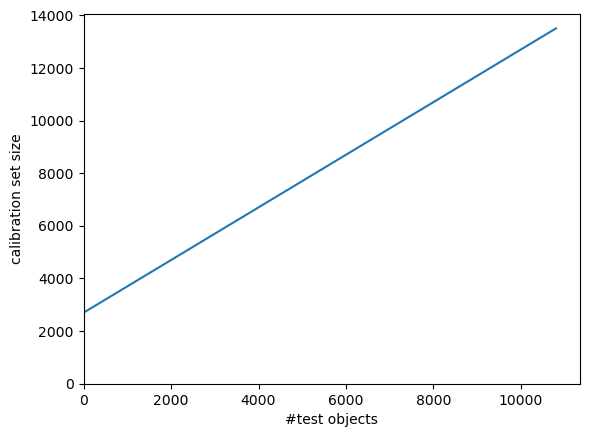

In [149]:
cpds = cps_norm.predict_cpds_online(y_hat_test, y_test, sigmas=sigmas_test_var)
plt.plot(np.arange(len(cpds)), [len(cpds[i]) for i in range(len(cpds))])
plt.xlabel("#test objects")
plt.ylabel("calibration set size")
plt.ylim(0)
plt.xlim(0)
plt.show()

For Mondrian conformal predictive systems, the calibration set for one of the categories will be extended with one element for each prediction; the size of the predicted cpd is dependent on which category the test object falls in.

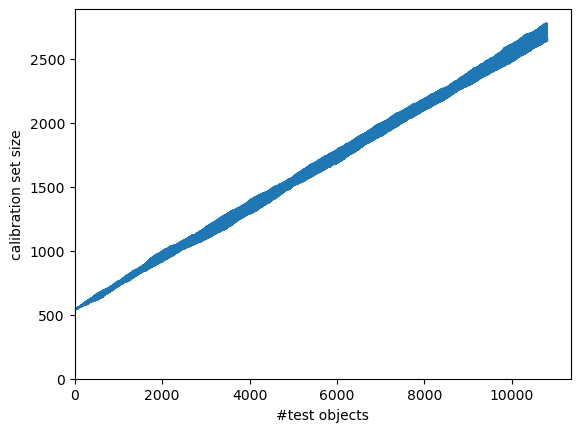

In [150]:
cpds = cps_mond_norm.predict_cpds_online(y_hat_test, y_test, 
                                         sigmas=sigmas_test_var, 
                                         bins=bins_test)
plt.plot(np.arange(len(cpds)), [len(cpds[i]) for i in range(len(cpds))])
plt.xlabel("#test objects")
plt.ylabel("calibration set size")
plt.ylim(0)
plt.xlim(0)
plt.show()

By default, the test objects and labels are sequentially added to the existing calibration set, i.e., the one used when fitting the conformal predictive system. We may set the `warm_start` option to `False`, if we would like to ignore the original calibration set. Note that the initial predictions tend to be very (maximally) wide, before we have a sufficiently large calibration set to allow for providing tighter intervals at the specified level of confidence.

In [151]:
cps_std.predict_int_online(y_hat_test, y_test, 
                           y_min=0, y_max=1, confidence=0.9,
                           warm_start=False)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.024138  , 0.06525427],
       [0.02434486, 0.06546113],
       [0.00893856, 0.05005483]])

In [152]:
cps_norm.predict_int_online(y_hat_test, y_test, 
                            sigmas=sigmas_test_var, 
                            y_min=0, y_max=1, confidence=0.9,
                            warm_start=False)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.02893135, 0.0589354 ],
       [0.03033607, 0.05786715],
       [0.01534491, 0.04201894]])

In [153]:
cps_mond_std.predict_int_online(y_hat_test, y_test, 
                                bins=bins_test, 
                                y_min=0, y_max=1, confidence=0.9,
                                warm_start=False)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.02850349, 0.05804063],
       [0.02871036, 0.05824749],
       [0.01747966, 0.03630942]])

In [154]:
cps_mond_norm.predict_int_online(y_hat_test, y_test, 
                                 sigmas=sigmas_test_var, bins=bins_test, 
                                 y_min=0, y_max=1, confidence=0.9,
                                 warm_start=False)

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.02924075, 0.05726356],
       [0.03061997, 0.05633311],
       [0.01785218, 0.03615382]])

Similarly, we may disable `warm_start` also when requesting percentiles using online calibration:

In [155]:
cps_std.predict_percentiles_online(y_hat_test, y_test, 
                                   lower_percentiles = [2.5, 25],
                                   higher_percentiles = [50, 75, 97.5],
                                   y_min=0, y_max=1, 
                                   warm_start=False)

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.40123079e-02, 1.00000000e+00,
        1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.67394821e-01, 1.00000000e+00,
        1.00000000e+00],
       ...,
       [1.61430348e-02, 3.76623132e-02, 4.29354938e-02, 4.81306096e-02,
        7.75198623e-02],
       [1.63498974e-02, 3.78691759e-02, 4.31423565e-02, 4.83388165e-02,
        7.77267250e-02],
       [9.43593967e-04, 2.24628724e-02, 2.77360530e-02, 3.29325130e-02,
        6.23204215e-02]])

In [156]:
cps_norm.predict_percentiles_online(y_hat_test, y_test, 
                                    sigmas=sigmas_test_var, 
                                    lower_percentiles = [2.5, 25],
                                    higher_percentiles = [50, 75, 97.5],
                                    y_min=0, y_max=1, 
                                    warm_start=False)

array([[0.        , 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 0.05320596, 1.        , 1.        ],
       [0.        , 0.        , 0.16089505, 1.        , 1.        ],
       ...,
       [0.02561059, 0.03810189, 0.04295594, 0.04793196, 0.06482842],
       [0.02728902, 0.03875076, 0.04320474, 0.04777216, 0.06327446],
       [0.0123927 , 0.02349764, 0.02781296, 0.03223821, 0.04725792]])

In [157]:
cps_mond_std.predict_percentiles_online(y_hat_test, y_test, 
                                        bins=bins_test, 
                                        lower_percentiles = [2.5, 25],
                                        higher_percentiles = [50, 75, 97.5],
                                        y_min=0, y_max=1, 
                                        warm_start=False)

array([[0.        , 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        , 1.        ],
       ...,
       [0.0247801 , 0.03797198, 0.04285818, 0.04815669, 0.06226766],
       [0.02498696, 0.03818508, 0.04306504, 0.04836355, 0.06247452],
       [0.01475657, 0.024672  , 0.02805354, 0.03086875, 0.03927496]])

In [158]:
cps_mond_norm.predict_percentiles_online(y_hat_test, y_test,
                                         sigmas=sigmas_test_var,
                                         bins=bins_test, 
                                         lower_percentiles = [2.5, 25],
                                         higher_percentiles = [50, 75, 97.5],
                                         y_min=0, y_max=1, 
                                         warm_start=False)

array([[0.        , 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        , 1.        ],
       ...,
       [0.02534627, 0.03814261, 0.04284592, 0.0482686 , 0.06153439],
       [0.02704648, 0.03879056, 0.04310378, 0.04807952, 0.06025192],
       [0.01547773, 0.02474128, 0.0280569 , 0.03082291, 0.03876334]])

We may set the `warm_start` option to `False` also when obtaining the conformal predictive distributions; this means that the size of the cpds will equal the number of already seen test objects for standard and normalized conformal predictive systems. 

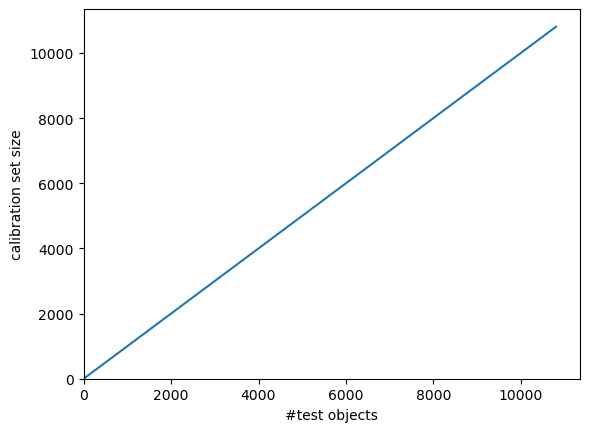

In [159]:
cpds = cps_std.predict_cpds_online(y_hat_test, y_test, 
                                    warm_start=False)
plt.plot(np.arange(len(cpds)), [len(cpds[i]) for i in range(len(cpds))])
plt.xlabel("#test objects")
plt.ylabel("calibration set size")
plt.ylim(0)
plt.xlim(0)
plt.show()

For Mondrian conformal predictive systems, the calibration set for each category will be initially empty when `warm_start` is disabled.

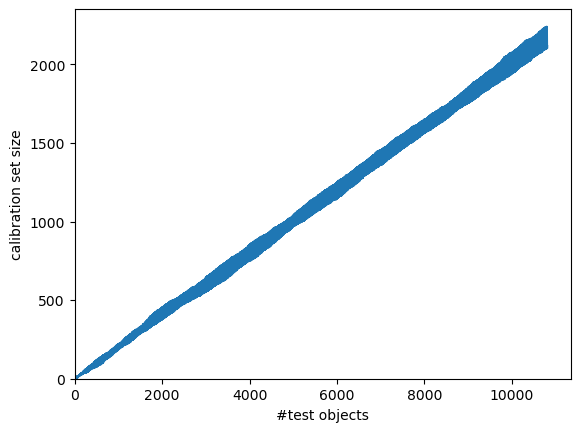

In [160]:
cpds = cps_mond_std.predict_cpds_online(y_hat_test, y_test, 
                                        bins=bins_test,
                                        warm_start=False)

plt.plot(np.arange(len(cpds)), [len(cpds[i]) for i in range(len(cpds))])
plt.xlabel("#test objects")
plt.ylabel("calibration set size")
plt.ylim(0)
plt.xlim(0)
plt.show()

We may also evaluate the conformal predictive sytems using online calibration, by specifying `online=True` for the `evaluate` method (note that the metric "CRPS" is not available for semi-online conformal predictive systems):

In [161]:
cps_std.evaluate(y_hat_test, y_test, 
                 confidence=0.99, y_min=0, y_max=1,
                 online=True)

{'error': 0.00925326177477559,
 'eff_mean': 0.13448955886386924,
 'eff_med': 0.13728409967213154,
 'time_fit': 0.00038886070251464844,
 'ks_test': 0.5916687621381072,
 'time_evaluate': 0.25008273124694824}

In [162]:
cps_norm.evaluate(y_hat_test, y_test, 
                  sigmas=sigmas_test_var, 
                  confidence=0.99, y_min=0, y_max=1, 
                  online=True)

{'error': 0.009345794392523366,
 'eff_mean': 0.0790979861269161,
 'eff_med': 0.06009874136210289,
 'time_fit': 0.00010728836059570312,
 'ks_test': 0.5444312633520503,
 'time_evaluate': 0.2582359313964844}

In [163]:
cps_mond_std.evaluate(y_hat_test, y_test, 
                      bins=bins_test, 
                      confidence=0.99, y_min=0, y_max=1, 
                      online=True)

{'error': 0.009808457481262134,
 'eff_mean': 0.09741711380709833,
 'eff_med': 0.06305689154098373,
 'time_fit': 0.0001480579376220703,
 'ks_test': 0.5446003431291417,
 'time_evaluate': 0.15784144401550293}

In [164]:
cps_mond_norm.evaluate(y_hat_test, y_test,
                       sigmas=sigmas_test_var,
                       bins=bins_test, 
                       confidence=0.99, y_min=0, y_max=1, 
                       online=True)

{'error': 0.007865272508559285,
 'eff_mean': 0.08363176946520014,
 'eff_med': 0.05911412793010452,
 'time_fit': 0.00018858909606933594,
 'ks_test': 0.5889786037265359,
 'time_evaluate': 0.16428828239440918}

Again, we may consider ignoring the original calibration set by setting `warm_start=False`:

In [165]:
cps_std.evaluate(y_hat_test, y_test, 
                 confidence=0.99, y_min=0, y_max=1, 
                 online=True, warm_start=False)

{'error': 0.009345794392523366,
 'eff_mean': 0.1499398333997363,
 'eff_med': 0.1357851606557381,
 'time_fit': 0.00038886070251464844,
 'ks_test': 0.5831142591489074,
 'time_evaluate': 0.2475731372833252}

In [166]:
cps_norm.evaluate(y_hat_test, y_test, 
                  sigmas=sigmas_test_var, 
                  confidence=0.99, y_min=0, y_max=1, 
                  online=True, warm_start=False)

{'error': 0.008975663921532373,
 'eff_mean': 0.09700046832436568,
 'eff_med': 0.06088790334805416,
 'time_fit': 0.00010728836059570312,
 'ks_test': 0.5347263113356433,
 'time_evaluate': 0.241180419921875}

In [167]:
cps_mond_std.evaluate(y_hat_test, y_test, 
                      bins=bins_test, 
                      confidence=0.99, y_min=0, y_max=1, 
                      online=True, warm_start=False)

{'error': 0.00731007680207274,
 'eff_mean': 0.18751414317258247,
 'eff_med': 0.06875509849180339,
 'time_fit': 0.0001480579376220703,
 'ks_test': 0.5508493406042637,
 'time_evaluate': 0.15447330474853516}

In [168]:
cps_mond_norm.evaluate(y_hat_test, y_test, 
                       sigmas=sigmas_test_var, 
                       bins=bins_test,
                       confidence=0.99, y_min=0, y_max=1, 
                       online=True, warm_start=False)

{'error': 0.007032478948829413,
 'eff_mean': 0.16887624253333153,
 'eff_med': 0.06258798487910244,
 'time_fit': 0.00018858909606933594,
 'ks_test': 0.5866258011785099,
 'time_evaluate': 0.19600462913513184}

#### Online calibration without an initial calibration set

Since the calibration set is incrementally extended during online calibration, we may consider starting with an empty calibration set; this allows us to use the full training set when fitting the underlying model. 

In [169]:
rf_full = RandomForestRegressor(n_jobs=-1, n_estimators=500)

rf_full.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

Let us compute non-conformity scores for the test set using the model trained on the full training set:

In [170]:
y_hat_full = rf_full.predict(X_test)

We may now create a conformal predictive system, but this time without fitting a calibration set:

In [171]:
cps_full = ConformalPredictiveSystem()

We may now obtain prediction intervals while sequentially updating the calibration set:

In [172]:
cps_full.predict_int_online(y_hat_full, y_test, confidence=0.9)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.02496865, 0.06507602],
       [0.02493484, 0.06504221],
       [0.00825071, 0.04835807]])

If we provide also difficulty estimates (`sigmas`), we will obtain a normalized conformal predictive system:

In [173]:
cps_full.predict_int_online(y_hat_full, y_test, sigmas=sigmas_test_var, confidence=0.9)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.0294355 , 0.0590041 ],
       [0.03059888, 0.0577304 ],
       [0.01432965, 0.04061657]])

We get a Mondrian conformal predictive system by providing the categories for the test set, here by dividing the predictions into seven intervals:

In [174]:
bin_thresholds = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.5, 1.0]
bins_test = binning(rf_full.predict(X_test), bin_thresholds)

cps_full.predict_int_online(y_hat_full, y_test, bins=bins_test, confidence=0.9)

array([[      -inf,        inf],
       [      -inf,        inf],
       [      -inf,        inf],
       ...,
       [0.02904611, 0.0586453 ],
       [0.0290123 , 0.05861149],
       [0.0158161 , 0.03672153]])

Let us investigate the coverage and prediction interval size for each category:

In [175]:
intervals = cps_full.predict_int_online(y_hat_full, y_test,
                                        bins=bins_test, y_min=0, y_max=1, 
                                        confidence=0.9)
number = []
coverage = []
size = []

for c in range(len(bin_thresholds)-1):
    selection = bins_test == c
    number.append(np.sum(selection))
    coverage.append(np.sum(
        (intervals[selection,0] <= y_test[selection])& \
        (y_test[selection] <= intervals[selection,1]))/np.sum(selection))
    size.append(np.sum(intervals[selection,1]-\
                       intervals[selection,0])/np.sum(selection))

df = pd.DataFrame({"Number":number, "Coverage":coverage, "Size":size})
df.round(4)

,Number,Coverage,Size
0,576,0.9080,0.0527
1,3223,0.9066,0.0277
2,2836,0.9129,0.0382
3,1937,0.8973,0.0496
4,1013,0.9161,0.0711
5,1217,0.9063,0.1460
6,5,1.0000,1.0000


We can use `predict_p_online` to get the p-values:

array([0.78895203, 0.80095738, 0.48688663, ..., 0.15023919, 0.65529523,
       0.11913314])

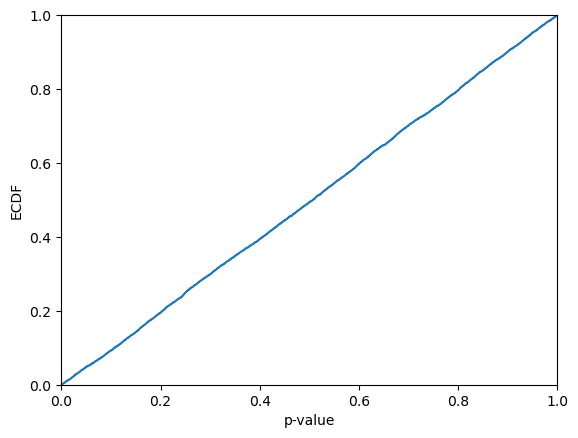

KS-test: 0.42158196806714776


In [176]:
p_values = cps_full.predict_p_online(y_hat_test, y_test, bins=bins_test)

display(p_values)

plt.ecdf(p_values)
plt.xlim(0,1)
plt.xlabel("p-value")
plt.ylabel("ECDF")
plt.show()

print(f"KS-test: {kstest(p_values, "uniform").pvalue}")

We may get percentiles from the Mondrian conformal predictive system:

In [177]:
cps_full.predict_percentiles_online(y_hat_test, y_test, 
                                    bins=bins_test, 
                                    lower_percentiles = [2.5, 25],
                                    higher_percentiles = [50, 75, 97.5],
                                    y_min=0, y_max=1)

array([[0.        , 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        , 1.        ],
       ...,
       [0.02439475, 0.03803148, 0.04302118, 0.04810387, 0.0629956 ],
       [0.02460161, 0.03825469, 0.04322805, 0.04831073, 0.06320246],
       [0.01320772, 0.02431748, 0.02777921, 0.03088502, 0.04100022]])

We can of course also request the cpds; here we take a close look at those belonging to category 5:

In [178]:
cpds = cps_full.predict_cpds_online(y_hat_test, y_test, bins=bins_test)

cpds[bins_test == 5]

array([array([], dtype=float64), array([0.19868549]),
       array([0.20822479, 0.21150652]), ...,
       array([-0.02734483,  0.010169  ,  0.01350467, ...,  0.33994047,
               0.34142273,  0.38479078])                              ,
       array([-0.03523275,  0.00228108,  0.00561675, ...,  0.33205255,
               0.33353481,  0.37690286])                              ,
       array([-0.05966609, -0.02215226, -0.01881659, ...,  0.30761922,
               0.30910148,  0.35246952])                              ],
      dtype=object)

We may also evaluate the conformal predictive system using online calibration, by specifying `online=True` for the `evaluate` method:

In [179]:
cps_full.evaluate(y_hat_full, y_test, y_min=0, y_max=1, confidence=0.9, 
                  online=True)

{'error': 0.09142222633478303,
 'eff_mean': 0.044345805857248,
 'eff_med': 0.04141641154098347,
 'time_fit': None,
 'ks_test': 0.5595363340963319,
 'time_evaluate': 0.22411704063415527}

For Mondrian conformal predictive systems, we just have to provide the categories:

In [180]:
cps_full.evaluate(y_hat_full, y_test, bins=bins_test, y_min=0, y_max=1, 
                  confidence=0.9, online=True)

{'error': 0.09244008513000834,
 'eff_mean': 0.053552572601571244,
 'eff_med': 0.0308474213770494,
 'time_fit': None,
 'ks_test': 0.27629219835851093,
 'time_evaluate': 0.16256952285766602}